In [7]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE

# Load the dataset
data_path = 'startdata.csv'
data = pd.read_csv(data_path)

# Display initial columns and first few rows to verify
print(data.columns)
print(data.head())

Index(['patientid', 'siteid', 'countryid', 'sex', 'age', 'timeonset',
       'location', 'haematemesis', 'melaena', 'variceal', 'sbpstatus', 'sbp',
       'hrstatus', 'heartrate', 'shock', 'bleeding', 'comorbcv', 'comorbresp',
       'comorbliver', 'comorbrenal', 'comorbmalig', 'comorbother', 'anticoag',
       'emergency', 'eligible', 'timerandtodeath', 'causedeath',
       'causedeathother', 'daysrandtodischarge', 'stillinhospday28',
       'diagnosticendoscopic', 'therapeuticendoscopic',
       'diagnosticradiological', 'therapeuticradiological',
       'surgicalintervention', 'causebleed', 'doseone', 'dosetwo',
       'helicobacter', 'h2', 'proton', 'vasopressin', 'antibiotics',
       'antifibrinolytics', 'transfused', 'blood', 'plasma', 'platelets',
       'daysicu', 'dayshdu', 'rebleeding', 'rebleedingnum', 'dvt', 'pe',
       'stroke', 'myocardialinfarction', 'cardiacevent', 'sepsis', 'pneumonia',
       'respiratoryfailure', 'liverfailure', 'renalfailure', 'seizure',
       'b

In [14]:
# Check the number of non-null values in causedeath and timerandtodeath columns
causedeath_count = data['causedeath'].notnull().sum()
timerandtodeath_count = data['timerandtodeath'].notnull().sum()

print(f"Number of non-null values in causedeath column: {causedeath_count}")
print(f"Number of non-null values in timerandtodeath column: {timerandtodeath_count}")

# Check if the counts are the same
if causedeath_count == timerandtodeath_count:
    print("Both columns have the same number of data points.")
else:
    print("The columns have different numbers of data points.")

Number of non-null values in causedeath column: 1108
Number of non-null values in timerandtodeath column: 1108
Both columns have the same number of data points.


In [15]:
#Step 1 Data Cleaning
import pandas as pd

# Strip any leading or trailing whitespace from column names
data.columns = data.columns.str.strip()

# Display initial columns and first few rows to verify
print(data.columns)
print(data.head())

# Drop the 'timerandtodeath' column as it is not needed for feature selection
data = data.drop(columns=['timerandtodeath','patientid', 'siteid', 'countryid','eligible','causedeathother','isserious1', 
                          'isserious2', 'isserious3', 'isserious4','isserious5','hrstatus','sbpstatus'])
# Define the threshold for missing values
missing_threshold = 0.2

# Separate the 'causedeath' column
causedeath_column = data['causedeath']

# Calculate the percentage of missing values for each column
missing_percentage = data.isnull().mean()

# Drop columns with more than the threshold percentage of missing values, excluding 'causedeath'
data = data.loc[:, (missing_percentage <= missing_threshold) | (data.columns == 'causedeath')]

# Add 'causedeath' column back if it was dropped
if 'causedeath' not in data.columns:
    data['causedeath'] = causedeath_column

# Display the remaining columns
print("Columns in the dataframe after dropping columns with more than 20% missing data:")
print(data.columns)
print(data.head())

Index(['patientid', 'siteid', 'countryid', 'sex', 'age', 'timeonset',
       'location', 'haematemesis', 'melaena', 'variceal', 'sbpstatus', 'sbp',
       'hrstatus', 'heartrate', 'shock', 'bleeding', 'comorbcv', 'comorbresp',
       'comorbliver', 'comorbrenal', 'comorbmalig', 'comorbother', 'anticoag',
       'emergency', 'eligible', 'timerandtodeath', 'causedeath',
       'causedeathother', 'daysrandtodischarge', 'stillinhospday28',
       'diagnosticendoscopic', 'therapeuticendoscopic',
       'diagnosticradiological', 'therapeuticradiological',
       'surgicalintervention', 'causebleed', 'doseone', 'dosetwo',
       'helicobacter', 'h2', 'proton', 'vasopressin', 'antibiotics',
       'antifibrinolytics', 'transfused', 'blood', 'plasma', 'platelets',
       'daysicu', 'dayshdu', 'rebleeding', 'rebleedingnum', 'dvt', 'pe',
       'stroke', 'myocardialinfarction', 'cardiacevent', 'sepsis', 'pneumonia',
       'respiratoryfailure', 'liverfailure', 'renalfailure', 'seizure',
       'b

In [16]:
#Step 1 A Transforming target variables
# Transform rebleeding to binary 1/0
data['rebleeding'] = data['rebleeding'].apply(lambda x: 1 if x == 'Yes' else 0)

# Transform causedeath to binary 1/0 for mortality
data['mortality'] = data['causedeath'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Transform long admission to binary 1/0
data['long_admission'] = data['daysrandtodischarge'].apply(lambda x: 1 if x > 14 else 0)

# Transform ICU admission to binary 1/0 (non-zero values)
data['icu_admission'] = data['daysicu'].apply(lambda x: 1 if x > 0 else 0)

# Transform HDU admission to binary 1/0 (non-zero values)
data['hdu_admission'] = data['dayshdu'].apply(lambda x: 1 if x > 0 else 0)

# Drop the original columns used for transformations if not needed as features
data.drop(columns=['causedeath', 'daysrandtodischarge', 'daysicu', 'dayshdu'], inplace=True)

# Display the transformed columns
print("Columns in the dataframe after transforming target variables:")
print(data.columns)
print(data.head())
data.to_csv('cleaned_data.csv', index=False)

Columns in the dataframe after transforming target variables:
Index(['sex', 'age', 'timeonset', 'location', 'haematemesis', 'melaena',
       'variceal', 'sbp', 'heartrate', 'shock', 'bleeding', 'comorbcv',
       'comorbresp', 'comorbliver', 'comorbrenal', 'comorbmalig',
       'comorbother', 'anticoag', 'emergency', 'diagnosticendoscopic',
       'therapeuticendoscopic', 'diagnosticradiological',
       'therapeuticradiological', 'surgicalintervention', 'causebleed',
       'doseone', 'dosetwo', 'helicobacter', 'h2', 'proton', 'vasopressin',
       'antibiotics', 'antifibrinolytics', 'transfused', 'rebleeding', 'dvt',
       'pe', 'stroke', 'myocardialinfarction', 'cardiacevent', 'sepsis',
       'pneumonia', 'respiratoryfailure', 'liverfailure', 'renalfailure',
       'seizure', 'bathing', 'dressing', 'toileting', 'transferring',
       'continence', 'feeding', 'GBS', 'Rockall', 'mortality',
       'long_admission', 'icu_admission', 'hdu_admission'],
      dtype='object')
      sex 

In [17]:
unique_values = data['causebleed'].unique()
print(unique_values)

['Upper GI bleed: Erosion or peptic ulcer' 'Upper GI bleed: Malignancy'
 'Upper GI bleed: Other/unknown' 'Lower GI bleed: Other/unknown'
 'Upper GI bleed: Varices' 'Lower GI bleed: Diverticular disease'
 'Lower GI bleed: Malignancy' 'Lower GI bleed: Colitis'
 'Upper GI bleed: Vascular lesion' 'Lower GI bleed: Vascular lesion'
 'Lower GI bleed: Infection' nan]


In [18]:
#Rockall score recalculation before going into ML modelling comparison and 

import pandas as pd

# Load cleaned dataset
data = pd.read_csv('cleaned_data.csv')

# Define functions to calculate each component of the Rockall score
def calculate_age_score(age):
    if age < 60:
        return 0
    elif 60 <= age < 80:
        return 1
    else:
        return 2

def calculate_shock_score(sbp, pulse):
    if sbp > 100 and pulse < 100:
        return 0
    elif sbp > 100 and pulse >= 100:
        return 1
    elif sbp < 100:
        return 2
    return 0

def calculate_comorbidity_score(row):
    if row['comorbcv'] == 'Yes' or row['comorbother'] == 'Yes':
        return 2
    if row['comorbrenal'] == 'Yes' or row['comorbliver'] == 'Yes' or row['comorbmalig'] == 'Yes':
        return 3
    return 0

def calculate_diagnosis_score(causebleed):
    if pd.isna(causebleed):
        return 1
    causebleed_mapping = {
        'Upper GI bleed: Erosion or peptic ulcer': 1,
        'Upper GI bleed: Malignancy': 2,
        'Upper GI bleed: Other/unknown': 1,
        'Lower GI bleed: Other/unknown': 1,
        'Upper GI bleed: Varices': 1,
        'Lower GI bleed: Diverticular disease': 1,
        'Lower GI bleed: Malignancy': 2,
        'Lower GI bleed: Colitis': 1,
        'Upper GI bleed: Vascular lesion': 1,
        'Lower GI bleed: Vascular lesion': 1,
        'Lower GI bleed: Infection': 1
    }
    return causebleed_mapping.get(causebleed, 1)

# Calculate each component of the Rockall score
data['age_score'] = data['age'].apply(calculate_age_score)
data['shock_score'] = data.apply(lambda row: calculate_shock_score(row['sbp'], row['heartrate']), axis=1)
data['comorbidity_score'] = data.apply(calculate_comorbidity_score, axis=1)
data['diagnosis_score'] = data['causebleed'].apply(calculate_diagnosis_score)

# Calculate full Rockall score
data['full_rockall_score'] = data['age_score'] + data['shock_score'] + data['comorbidity_score'] + data['diagnosis_score']

# Drop the intermediate score columns if not needed
data.drop(columns=['age_score', 'shock_score', 'comorbidity_score', 'diagnosis_score'], inplace=True)

# Display the dataset with the new full Rockall score
print(data[['age', 'sbp', 'heartrate', 'causebleed', 'full_rockall_score']].head())

# Save the updated dataframe to a new CSV file
data.to_csv('cleaned_data_with_full_rockall_score.csv', index=False)

   age  sbp  heartrate                               causebleed  \
0   88  111        102  Upper GI bleed: Erosion or peptic ulcer   
1   79   83        107  Upper GI bleed: Erosion or peptic ulcer   
2   81  116        105               Upper GI bleed: Malignancy   
3   34  119        112            Upper GI bleed: Other/unknown   
4   88  130         87  Upper GI bleed: Erosion or peptic ulcer   

   full_rockall_score  
0                   4  
1                   6  
2                   7  
3                   4  
4                   5  


In [19]:
#Evaluation of GBS and Rocakall performance with all targets
# Load the final dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_selection import RFE

data = pd.read_csv('cleaned_data_with_full_rockall_score.csv')

# Define thresholds
gbs_threshold = 6
rockall_threshold = 3

# Transform GBS to binary 1/0
data['gbs_adverse'] = data['GBS'].apply(lambda x: 1 if x >= gbs_threshold else 0)

# Transform Rockall to binary 1/0
data['rockall_adverse'] = data['full_rockall_score'].apply(lambda x: 1 if x >= rockall_threshold else 0)

# Drop columns that are not features
data.drop(columns=['GBS', 'full_rockall_score'], inplace=True)

# Display the transformed columns
print("Columns in the dataframe after transforming GBS and Rockall scores:")
print(data.columns)
print(data.head())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_scores(data, target, score_column):
    y_true = data[target]
    y_pred = data[score_column]
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# List of target variables
target_variables = ['mortality', 'rebleeding', 'long_admission', 'icu_admission', 'hdu_admission']

# Evaluate GBS and Rockall scores for all target variables
for target in target_variables:
    gbs_metrics = evaluate_scores(data, target, 'gbs_adverse')
    rockall_metrics = evaluate_scores(data, target, 'rockall_adverse')
    
    print(f"\nGBS Score Metrics ({target.capitalize()}):")
    print(f"Accuracy: {gbs_metrics[0]}")
    print(f"Precision: {gbs_metrics[1]}")
    print(f"Recall: {gbs_metrics[2]}")
    print(f"F1 Score: {gbs_metrics[3]}")
    print(f"ROC AUC Score: {gbs_metrics[4]}")
    
    print(f"\nRockall Score Metrics ({target.capitalize()}):")
    print(f"Accuracy: {rockall_metrics[0]}")
    print(f"Precision: {rockall_metrics[1]}")
    print(f"Recall: {rockall_metrics[2]}")
    print(f"F1 Score: {rockall_metrics[3]}")
    print(f"ROC AUC Score: {rockall_metrics[4]}")

Columns in the dataframe after transforming GBS and Rockall scores:
Index(['sex', 'age', 'timeonset', 'location', 'haematemesis', 'melaena',
       'variceal', 'sbp', 'heartrate', 'shock', 'bleeding', 'comorbcv',
       'comorbresp', 'comorbliver', 'comorbrenal', 'comorbmalig',
       'comorbother', 'anticoag', 'emergency', 'diagnosticendoscopic',
       'therapeuticendoscopic', 'diagnosticradiological',
       'therapeuticradiological', 'surgicalintervention', 'causebleed',
       'doseone', 'dosetwo', 'helicobacter', 'h2', 'proton', 'vasopressin',
       'antibiotics', 'antifibrinolytics', 'transfused', 'rebleeding', 'dvt',
       'pe', 'stroke', 'myocardialinfarction', 'cardiacevent', 'sepsis',
       'pneumonia', 'respiratoryfailure', 'liverfailure', 'renalfailure',
       'seizure', 'bathing', 'dressing', 'toileting', 'transferring',
       'continence', 'feeding', 'Rockall', 'mortality', 'long_admission',
       'icu_admission', 'hdu_admission', 'gbs_adverse', 'rockall_adverse'],

In [20]:
#Data Preprocessing check
import pandas as pd

# Load the dataset
data = pd.read_csv('cleaned_data_with_full_rockall_score.csv')

# Display column names and the first few rows to verify the data
print("Columns in the dataframe:")
print(data.columns)

print("\nFirst few rows of the dataframe:")
print(data.head())

Columns in the dataframe:
Index(['sex', 'age', 'timeonset', 'location', 'haematemesis', 'melaena',
       'variceal', 'sbp', 'heartrate', 'shock', 'bleeding', 'comorbcv',
       'comorbresp', 'comorbliver', 'comorbrenal', 'comorbmalig',
       'comorbother', 'anticoag', 'emergency', 'diagnosticendoscopic',
       'therapeuticendoscopic', 'diagnosticradiological',
       'therapeuticradiological', 'surgicalintervention', 'causebleed',
       'doseone', 'dosetwo', 'helicobacter', 'h2', 'proton', 'vasopressin',
       'antibiotics', 'antifibrinolytics', 'transfused', 'rebleeding', 'dvt',
       'pe', 'stroke', 'myocardialinfarction', 'cardiacevent', 'sepsis',
       'pneumonia', 'respiratoryfailure', 'liverfailure', 'renalfailure',
       'seizure', 'bathing', 'dressing', 'toileting', 'transferring',
       'continence', 'feeding', 'GBS', 'Rockall', 'mortality',
       'long_admission', 'icu_admission', 'hdu_admission',
       'full_rockall_score'],
      dtype='object')

First few rows o

In [21]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
  Using cached nvidia_nccl_cu12-2.22.3-py3-none-manylinux2014_x86_64.whl (190.9 MB)


In [22]:
#Dataset preprocessing again due to some error

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define features and target variables
target_variables = ['rebleeding', 'mortality', 'long_admission', 'icu_admission', 'hdu_admission']
features = data.columns.difference(target_variables + ['GBS', 'Rockall', 'full_rockall_score']).tolist()

X = data[features]
y = data[target_variables]

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Apply the preprocessing steps to the features
X_preprocessed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Ensure correct target variable splits
y_train_rebleeding = y_train['rebleeding']
y_test_rebleeding = y_test['rebleeding']
y_train_mortality = y_train['mortality']
y_test_mortality = y_test['mortality']
y_train_long_admission = y_train['long_admission']
y_test_long_admission = y_test['long_admission']
y_train_icu_admission = y_train['icu_admission']
y_test_icu_admission = y_test['icu_admission']
y_train_hdu_admission = y_train['hdu_admission']
y_test_hdu_admission = y_test['hdu_admission']

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import joblib
import numpy as np

# Define target variables and features
target_variables = ['rebleeding', 'mortality', 'long_admission', 'icu_admission', 'hdu_admission']
features = data.columns.difference(target_variables + ['GBS', 'Rockall', 'full_rockall_score']).tolist()

X = data[features]
y = data[target_variables]

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

# Apply the preprocessing steps to the features
X_preprocessed = preprocessor.fit_transform(X)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.joblib')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Save the preprocessed training and testing data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Ensure correct target variable splits
y_train_rebleeding = y_train['rebleeding']
y_test_rebleeding = y_test['rebleeding']
y_train_mortality = y_train['mortality']
y_test_mortality = y_test['mortality']
y_train_long_admission = y_train['long_admission']
y_test_long_admission = y_test['long_admission']
y_train_icu_admission = y_train['icu_admission']
y_test_icu_admission = y_test['icu_admission']
y_train_hdu_admission = y_train['hdu_admission']
y_test_hdu_admission = y_test['hdu_admission']

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'Neural Network': MLPClassifier(max_iter=10000)
}

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, target):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Save the trained model
    joblib.dump(model, f"{model_name}_{target}.joblib")
    
    return accuracy, precision, recall, f1, roc_auc

# Train and evaluate models for each target variable
results = {}

for target in target_variables:
    results[target] = {}
    for model_name, model in models.items():
        if target == 'rebleeding':
            metrics = evaluate_model(model, X_train, X_test, y_train_rebleeding, y_test_rebleeding, model_name, target)
        elif target == 'mortality':
            metrics = evaluate_model(model, X_train, X_test, y_train_mortality, y_test_mortality, model_name, target)
        elif target == 'long_admission':
            metrics = evaluate_model(model, X_train, X_test, y_train_long_admission, y_test_long_admission, model_name, target)
        elif target == 'icu_admission':
            metrics = evaluate_model(model, X_train, X_test, y_train_icu_admission, y_test_icu_admission, model_name, target)
        elif target == 'hdu_admission':
            metrics = evaluate_model(model, X_train, X_test, y_train_hdu_admission, y_test_hdu_admission, model_name, target)
        
        results[target][model_name] = {
            'Accuracy': metrics[0],
            'Precision': metrics[1],
            'Recall': metrics[2],
            'F1 Score': metrics[3],
            'ROC AUC Score': metrics[4]
        }

# Display results
for target, target_results in results.items():
    print(f"Results for {target}:")
    for model_name, metrics in target_results.items():
        print(f"{model_name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for rebleeding:
Logistic Regression:
Accuracy: 0.9430
Precision: 0.5094
Recall: 0.1971
F1 Score: 0.2842
ROC AUC Score: 0.8443

Random Forest:
Accuracy: 0.9434
Precision: 0.5263
Recall: 0.1460
F1 Score: 0.2286
ROC AUC Score: 0.8416

Gradient Boosting:
Accuracy: 0.9413
Precision: 0.4667
Recall: 0.1533
F1 Score: 0.2308
ROC AUC Score: 0.8419

SVM:
Accuracy: 0.9438
Precision: 1.0000
Recall: 0.0219
F1 Score: 0.0429
ROC AUC Score: 0.8011

K-Nearest Neighbors:
Accuracy: 0.9342
Precision: 0.3148
Recall: 0.1241
F1 Score: 0.1780
ROC AUC Score: 0.7181

Naive Bayes:
Accuracy: 0.8374
Precision: 0.2075
Recall: 0.6496
F1 Score: 0.3145
ROC AUC Score: 0.8066

AdaBoost:
Accuracy: 0.9376
Precision: 0.4032
Recall: 0.1825
F1 Score: 0.2513
ROC AUC Score: 0.8258

XGBoost:
Accuracy: 0.9371
Precision: 0.4110
Recall: 0.2190
F1 Score: 0.2857
ROC AUC Score: 0.8267

Neural Network:
Accuracy: 0.9208
Precision: 0.3169
Recall: 0.3285
F1 Score: 0.3226
ROC AUC Score: 0.7258

Results for mortality:
Logistic Regre

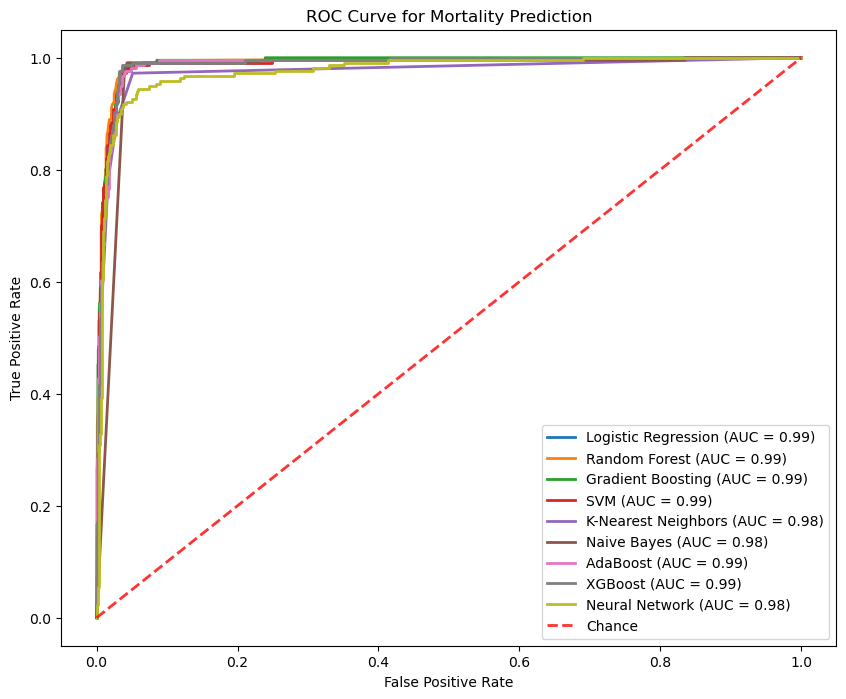

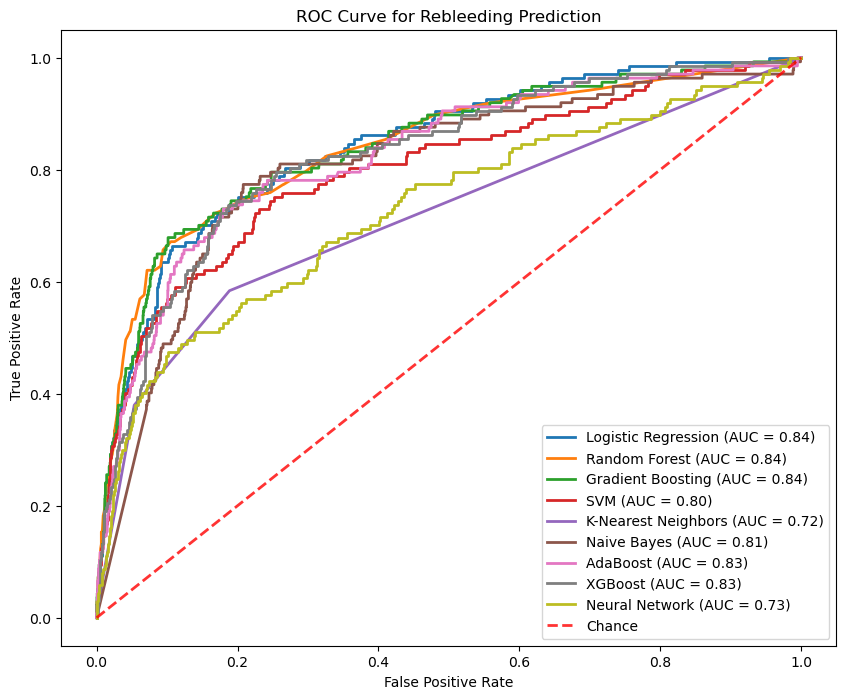

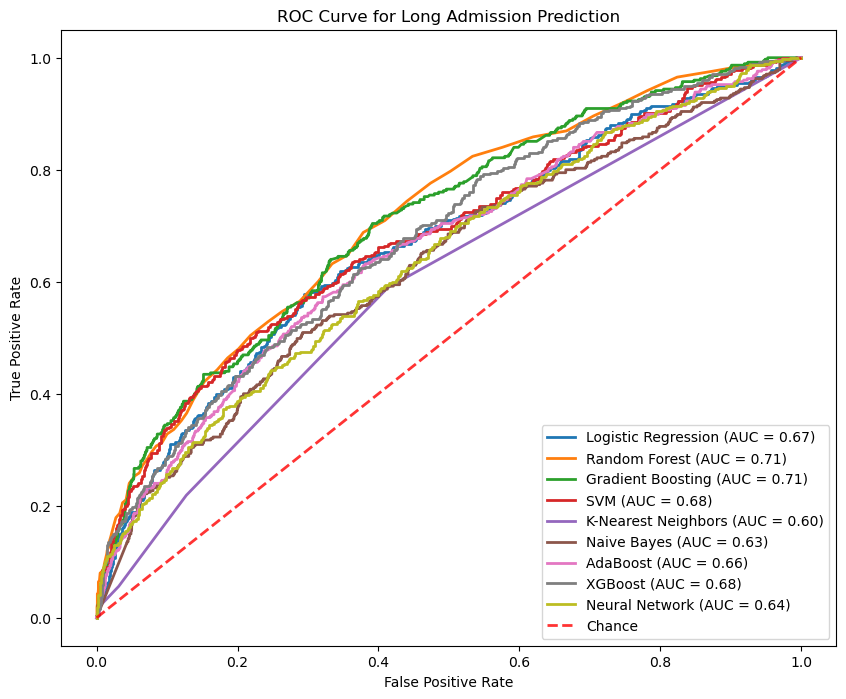

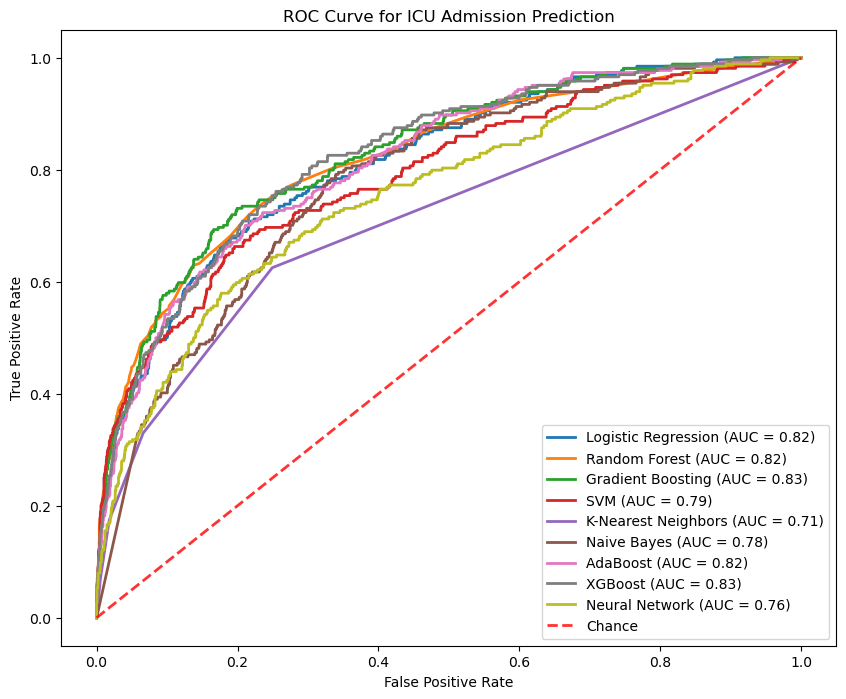

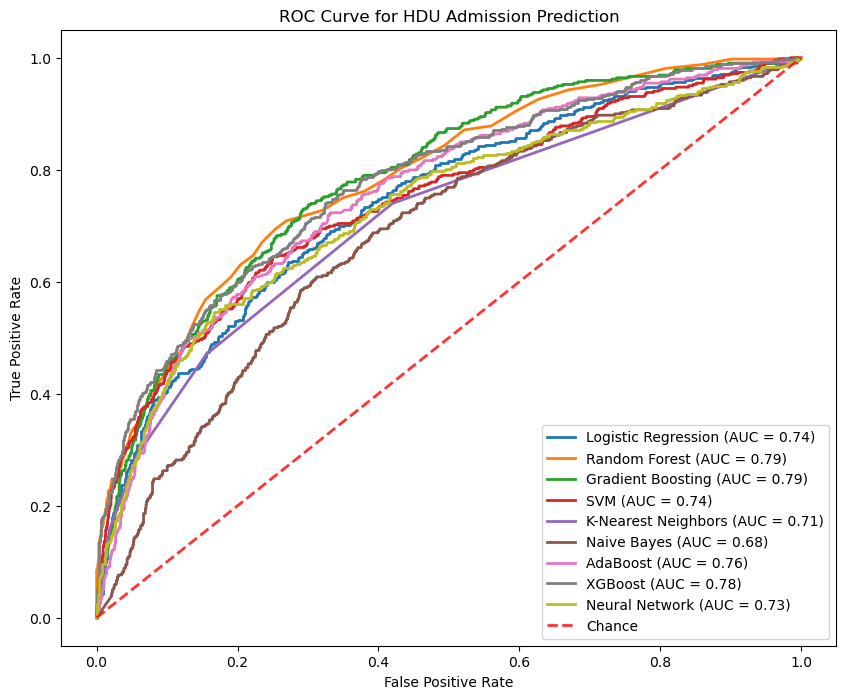

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import joblib
import numpy as np

# Load preprocessed data
X_test = np.load('X_test.npy')
y_test = pd.read_csv('y_test.csv')

# Ensure correct target variable splits
y_test_rebleeding = y_test['rebleeding']
y_test_mortality = y_test['mortality']
y_test_long_admission = y_test['long_admission']
y_test_icu_admission = y_test['icu_admission']
y_test_hdu_admission = y_test['hdu_admission']

# Function to plot ROC curves using saved models
def plot_roc_curve(models, X_test, y_test, title, target):
    plt.figure(figsize=(10, 8))
    for model_name in models.keys():
        # Load the saved model
        model = joblib.load(f"{model_name}_{target}.joblib")
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plotting ROC curves for each target variable using loaded models
plot_roc_curve(models, X_test, y_test_mortality, 'ROC Curve for Mortality Prediction', 'mortality')
plot_roc_curve(models, X_test, y_test_rebleeding, 'ROC Curve for Rebleeding Prediction', 'rebleeding')
plot_roc_curve(models, X_test, y_test_long_admission, 'ROC Curve for Long Admission Prediction', 'long_admission')
plot_roc_curve(models, X_test, y_test_icu_admission, 'ROC Curve for ICU Admission Prediction', 'icu_admission')
plot_roc_curve(models, X_test, y_test_hdu_admission, 'ROC Curve for HDU Admission Prediction', 'hdu_admission')

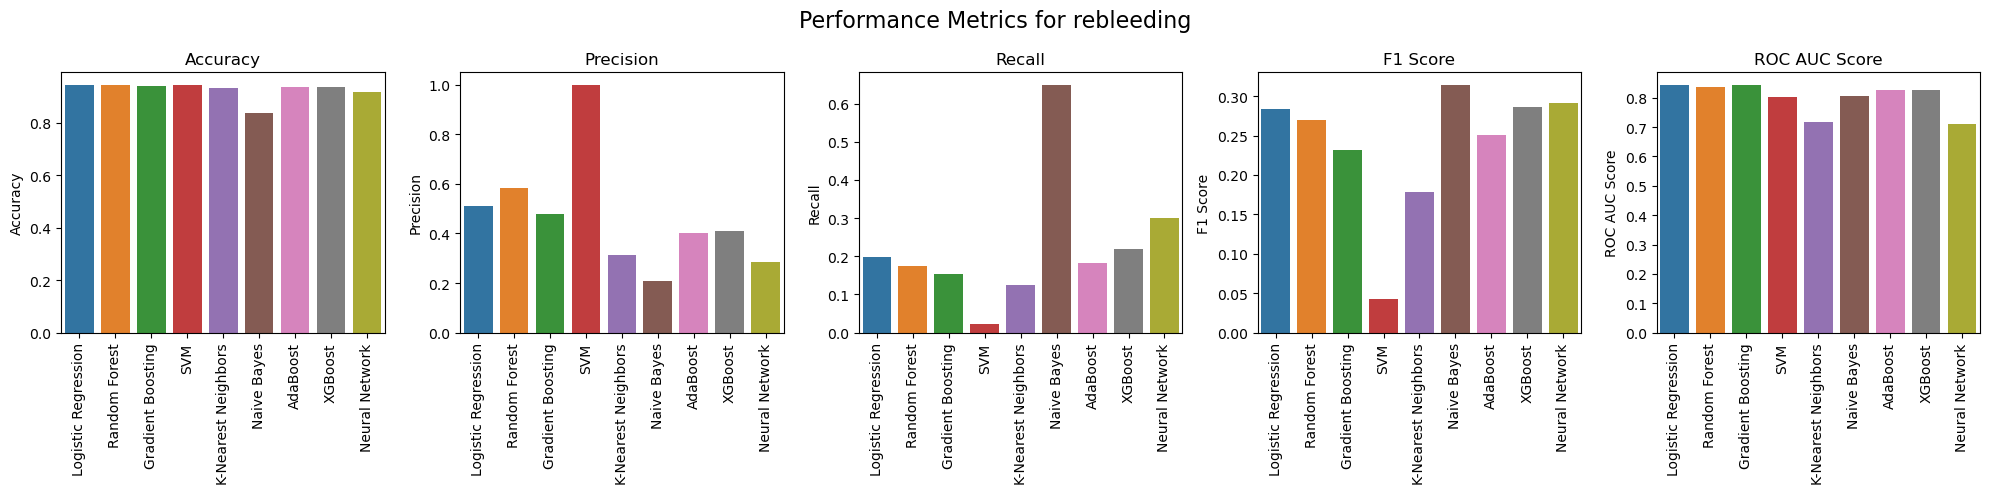

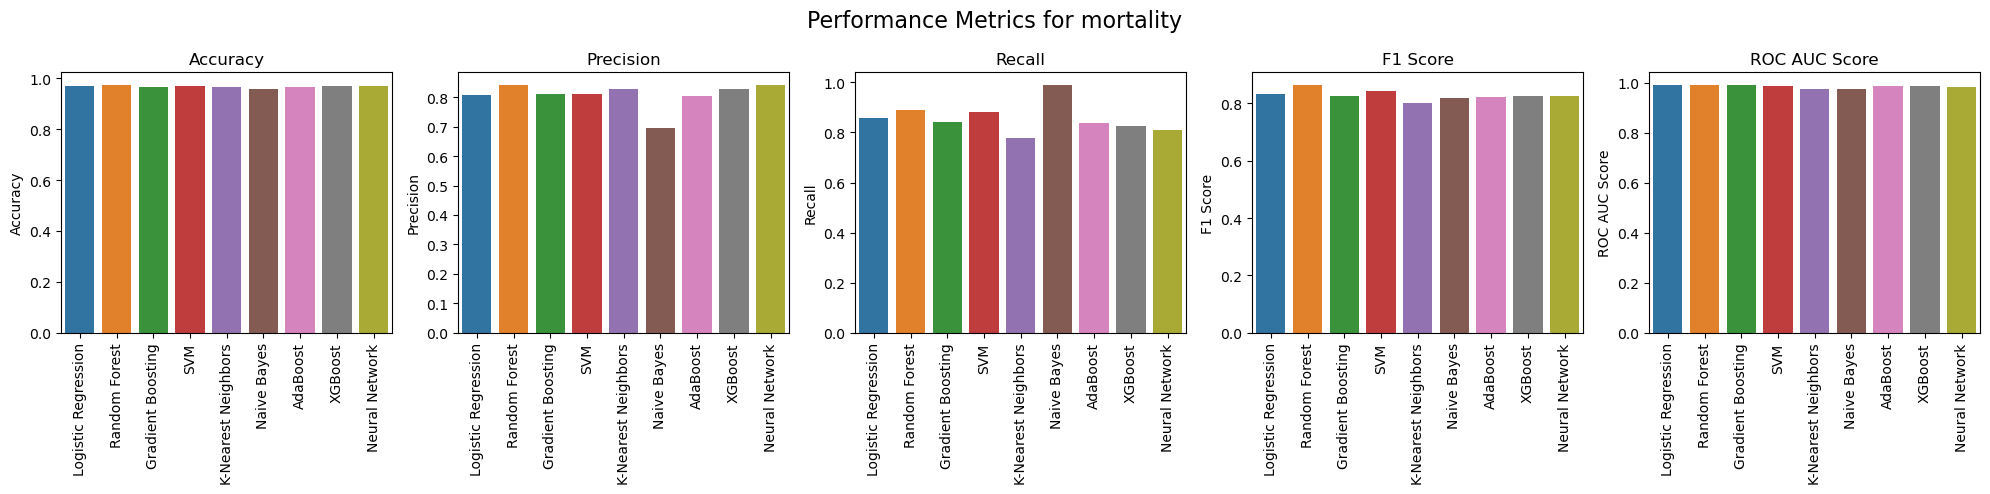

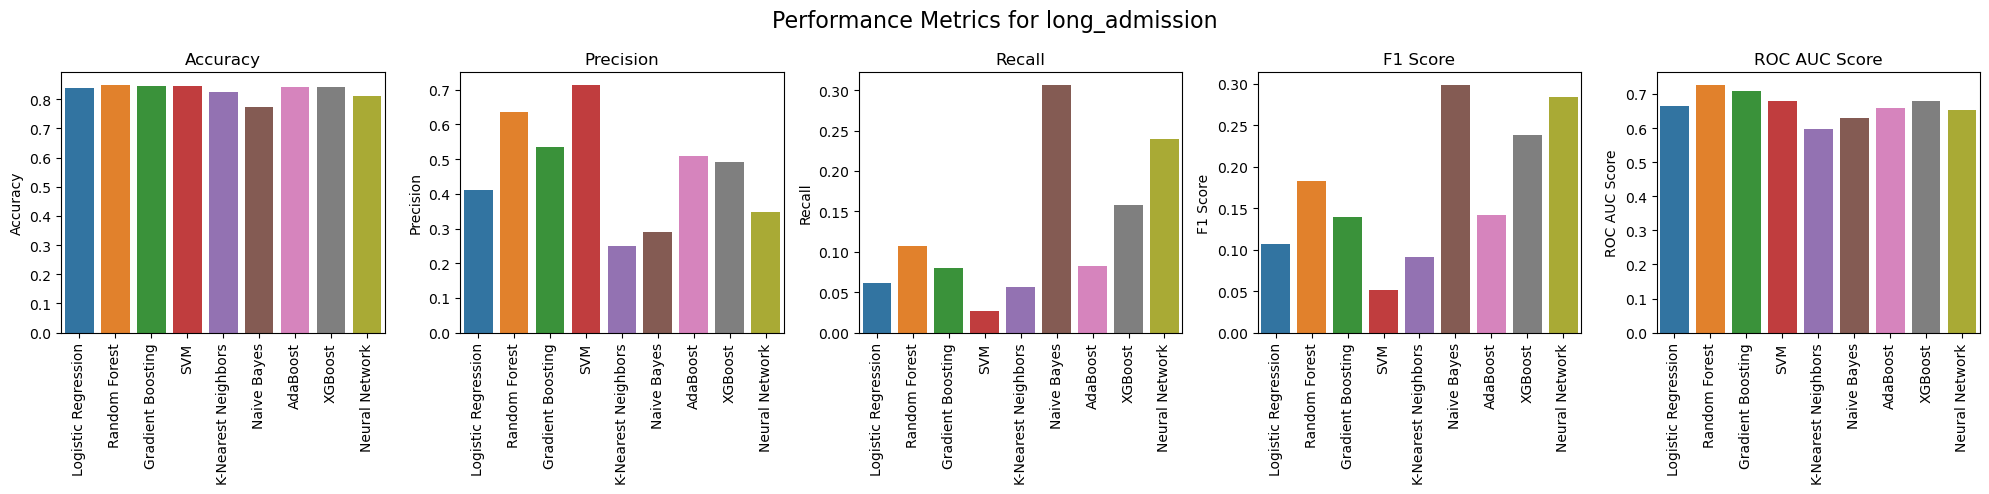

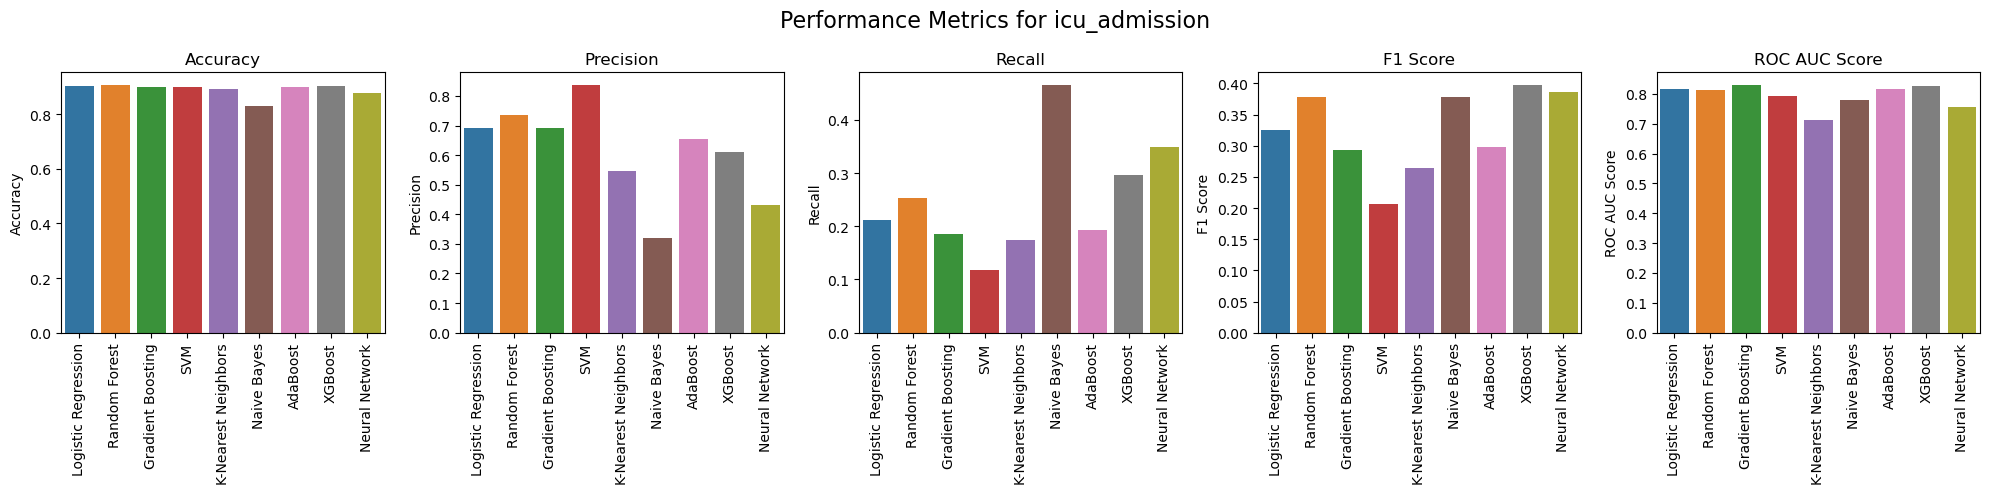

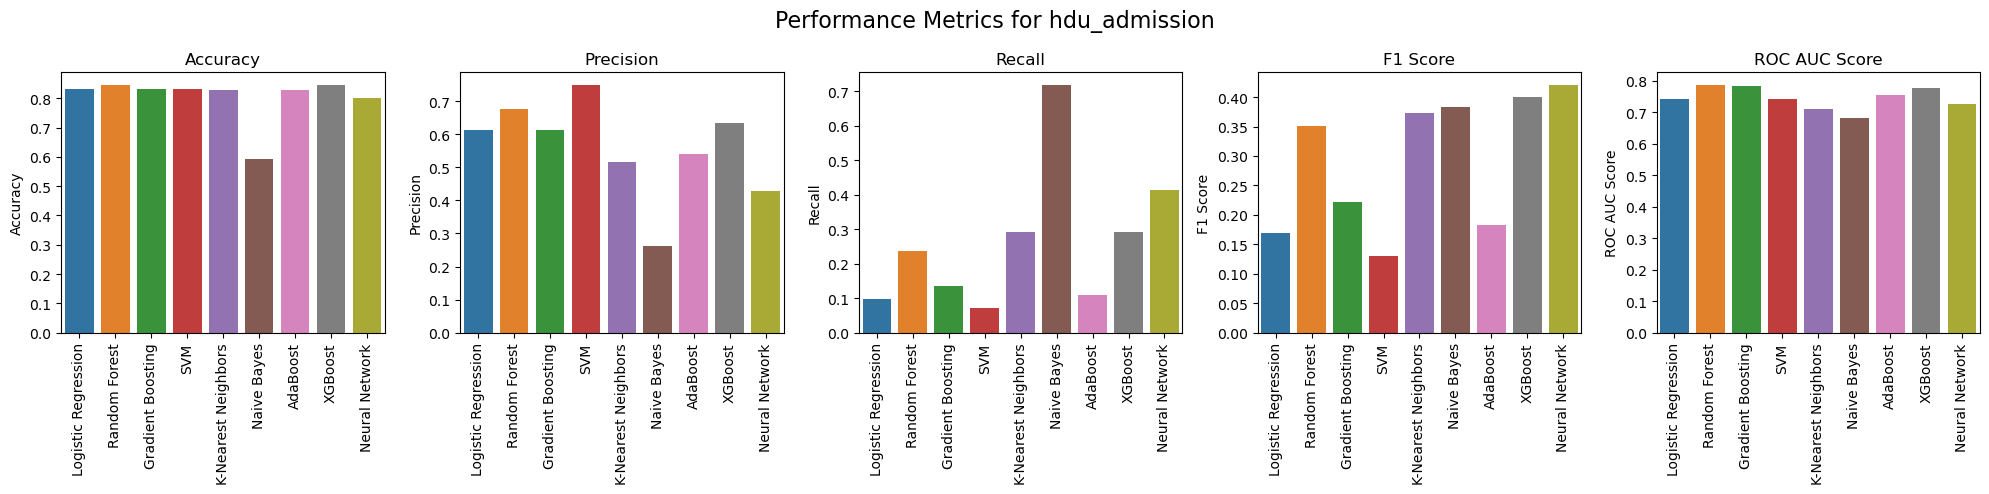

In [42]:
#Plot performance metrics

import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot performance metrics
def plot_metrics(results, target_variable, metrics):
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
    fig.suptitle(f'Performance Metrics for {target_variable}', fontsize=16)

    for i, metric in enumerate(metrics):
        data = {model: results[target_variable][model][metric] for model in results[target_variable]}
        sns.barplot(x=list(data.keys()), y=list(data.values()), ax=axes[i])
        axes[i].set_title(metric)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()

# Define the metrics to plot
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# Plot metrics for each target variable
for target in target_variables:
    plot_metrics(results, target, metrics_to_plot)

In [80]:
#Identifying best performing models
# Function to identify the best-performing model for each metric
def identify_best_model(results, target_variable):
    best_models = {}
    for metric in metrics_to_plot:
        best_model = max(results[target_variable], key=lambda model: results[target_variable][model][metric])
        best_models[metric] = best_model
    return best_models

# Identify best models for each target variable
best_models = {target: identify_best_model(results, target) for target in target_variables}

# Print the best-performing models
for target, models in best_models.items():
    print(f"Best models for {target}:")
    for metric, model in models.items():
        print(f"{metric}: {model}")
    print()

Best models for rebleeding:
Accuracy: Random Forest
Precision: SVM
Recall: Naive Bayes
F1 Score: Neural Network
ROC AUC Score: Logistic Regression

Best models for mortality:
Accuracy: Random Forest
Precision: Neural Network
Recall: Naive Bayes
F1 Score: Random Forest
ROC AUC Score: Gradient Boosting

Best models for long_admission:
Accuracy: Random Forest
Precision: SVM
Recall: Naive Bayes
F1 Score: Naive Bayes
ROC AUC Score: Random Forest

Best models for icu_admission:
Accuracy: Random Forest
Precision: SVM
Recall: Naive Bayes
F1 Score: XGBoost
ROC AUC Score: Gradient Boosting

Best models for hdu_admission:
Accuracy: Random Forest
Precision: SVM
Recall: Naive Bayes
F1 Score: Neural Network
ROC AUC Score: Random Forest



In [5]:
import pandas as pd

# Function to create summary tables for performance metrics
def create_summary_table(results, target_variable, metrics):
    summary_data = {model: [results[target_variable][model][metric] for metric in metrics] 
                    for model in results[target_variable]}
    summary_df = pd.DataFrame(summary_data, index=metrics)
    return summary_df

# Metrics to display
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# Target variables
target_variables = ['mortality', 'rebleeding', 'long_admission', 'icu_admission', 'hdu_admission']

# Results data structure with all target variables
results = {
    'mortality': {
        'Random Forest': {'Accuracy': 0.9723, 'Precision': 0.8240, 'Recall': 0.8848, 'F1 Score': 0.8533, 'ROC AUC Score': 0.9875},
        'Gradient Boosting': {'Accuracy': 0.9690, 'Precision': 0.8150, 'Recall': 0.8525, 'F1 Score': 0.8333, 'ROC AUC Score': 0.9904},
        'Neural Network': {'Accuracy': 0.9690, 'Precision': 0.8206, 'Recall': 0.8433, 'F1 Score': 0.8318, 'ROC AUC Score': 0.9798},
        'GBS Score': {'Accuracy': 0.3598, 'Precision': 0.1139, 'Recall': 0.8691, 'F1 Score': 0.2014, 'ROC AUC Score': 0.5884},
        'Rockall Score': {'Accuracy': 0.2619, 'Precision': 0.1071, 'Recall': 0.9468, 'F1 Score': 0.1924, 'ROC AUC Score': 0.5693}
    },
    'rebleeding': {
        'Random Forest': {'Accuracy': 0.9451, 'Precision': 0.5682, 'Recall': 0.1825, 'F1 Score': 0.2762, 'ROC AUC Score': 0.8431},
        'Logistic Regression': {'Accuracy': 0.9430, 'Precision': 0.5094, 'Recall': 0.1971, 'F1 Score': 0.2842, 'ROC AUC Score': 0.8443},
        'K-Nearest Neighbors': {'Accuracy': 0.9342, 'Precision': 0.3148, 'Recall': 0.1241, 'F1 Score': 0.1780, 'ROC AUC Score': 0.7181},
        'GBS Score': {'Accuracy': 0.3530, 'Precision': 0.0941, 'Recall': 0.9310, 'F1 Score': 0.1710, 'ROC AUC Score': 0.6197},
        'Rockall Score': {'Accuracy': 0.2304, 'Precision': 0.0750, 'Recall': 0.8596, 'F1 Score': 0.1380, 'ROC AUC Score': 0.5208}
    },
    'long_admission': {
        'Random Forest': {'Accuracy': 0.8462, 'Precision': 0.5690, 'Recall': 0.0880, 'F1 Score': 0.1524, 'ROC AUC Score': 0.7224},
        'Gradient Boosting': {'Accuracy': 0.8445, 'Precision': 0.5357, 'Recall': 0.0800, 'F1 Score': 0.1392, 'ROC AUC Score': 0.7074},
        'Neural Network': {'Accuracy': 0.7942, 'Precision': 0.3333, 'Recall': 0.3093, 'F1 Score': 0.3209, 'ROC AUC Score': 0.6506},
        'GBS Score': {'Accuracy': 0.3911, 'Precision': 0.1856, 'Recall': 0.8063, 'F1 Score': 0.3017, 'ROC AUC Score': 0.5582},
        'Rockall Score': {'Accuracy': 0.2979, 'Precision': 0.1718, 'Recall': 0.8649, 'F1 Score': 0.2867, 'ROC AUC Score': 0.5261}
    },
    'icu_admission': {
        'Random Forest': {'Accuracy': 0.9086, 'Precision': 0.7500, 'Recall': 0.2614, 'F1 Score': 0.3876, 'ROC AUC Score': 0.8165},
        'XGBoost': {'Accuracy': 0.9011, 'Precision': 0.6094, 'Recall': 0.2955, 'F1 Score': 0.3980, 'ROC AUC Score': 0.8265},
        'Neural Network': {'Accuracy': 0.8877, 'Precision': 0.4885, 'Recall': 0.3220, 'F1 Score': 0.3881, 'ROC AUC Score': 0.7731},
        'GBS Score': {'Accuracy': 0.3787, 'Precision': 0.1364, 'Recall': 0.9129, 'F1 Score': 0.2373, 'ROC AUC Score': 0.6142},
        'Rockall Score': {'Accuracy': 0.2646, 'Precision': 0.1167, 'Recall': 0.9050, 'F1 Score': 0.2067, 'ROC AUC Score': 0.5469}
    },
    'hdu_admission': {
        'Random Forest': {'Accuracy': 0.8466, 'Precision': 0.6853, 'Recall': 0.2339, 'F1 Score': 0.3488, 'ROC AUC Score': 0.7838},
        'Gradient Boosting': {'Accuracy': 0.8332, 'Precision': 0.6129, 'Recall': 0.1360, 'F1 Score': 0.2227, 'ROC AUC Score': 0.7852},
        'Neural Network': {'Accuracy': 0.8039, 'Precision': 0.4290, 'Recall': 0.3532, 'F1 Score': 0.3874, 'ROC AUC Score': 0.7207},
        'GBS Score': {'Accuracy': 0.4127, 'Precision': 0.2128, 'Recall': 0.8371, 'F1 Score': 0.3393, 'ROC AUC Score': 0.5783},
        'Rockall Score': {'Accuracy': 0.3228, 'Precision': 0.1973, 'Recall': 0.8995, 'F1 Score': 0.3237, 'ROC AUC Score': 0.5478}
    }
}

# Create and display summary tables for each target variable
for target in target_variables:
    summary_table = create_summary_table(results, target, metrics_to_plot)
    print(f"Summary Table for {target}:")
    display(summary_table)
    print("\n")

Summary Table for mortality:


,Random Forest,Gradient Boosting,Neural Network,GBS Score,Rockall Score
Accuracy,0.9723,0.9690,0.9690,0.3598,0.2619
Precision,0.8240,0.8150,0.8206,0.1139,0.1071
Recall,0.8848,0.8525,0.8433,0.8691,0.9468
F1 Score,0.8533,0.8333,0.8318,0.2014,0.1924
ROC AUC Score,0.9875,0.9904,0.9798,0.5884,0.5693




Summary Table for rebleeding:


,Random Forest,Logistic Regression,K-Nearest Neighbors,GBS Score,Rockall Score
Accuracy,0.9451,0.9430,0.9342,0.3530,0.2304
Precision,0.5682,0.5094,0.3148,0.0941,0.0750
Recall,0.1825,0.1971,0.1241,0.9310,0.8596
F1 Score,0.2762,0.2842,0.1780,0.1710,0.1380
ROC AUC Score,0.8431,0.8443,0.7181,0.6197,0.5208




Summary Table for long_admission:


,Random Forest,Gradient Boosting,Neural Network,GBS Score,Rockall Score
Accuracy,0.8462,0.8445,0.7942,0.3911,0.2979
Precision,0.5690,0.5357,0.3333,0.1856,0.1718
Recall,0.0880,0.0800,0.3093,0.8063,0.8649
F1 Score,0.1524,0.1392,0.3209,0.3017,0.2867
ROC AUC Score,0.7224,0.7074,0.6506,0.5582,0.5261




Summary Table for icu_admission:


,Random Forest,XGBoost,Neural Network,GBS Score,Rockall Score
Accuracy,0.9086,0.9011,0.8877,0.3787,0.2646
Precision,0.7500,0.6094,0.4885,0.1364,0.1167
Recall,0.2614,0.2955,0.3220,0.9129,0.9050
F1 Score,0.3876,0.3980,0.3881,0.2373,0.2067
ROC AUC Score,0.8165,0.8265,0.7731,0.6142,0.5469




Summary Table for hdu_admission:


,Random Forest,Gradient Boosting,Neural Network,GBS Score,Rockall Score
Accuracy,0.8466,0.8332,0.8039,0.4127,0.3228
Precision,0.6853,0.6129,0.4290,0.2128,0.1973
Recall,0.2339,0.1360,0.3532,0.8371,0.8995
F1 Score,0.3488,0.2227,0.3874,0.3393,0.3237
ROC AUC Score,0.7838,0.7852,0.7207,0.5783,0.5478


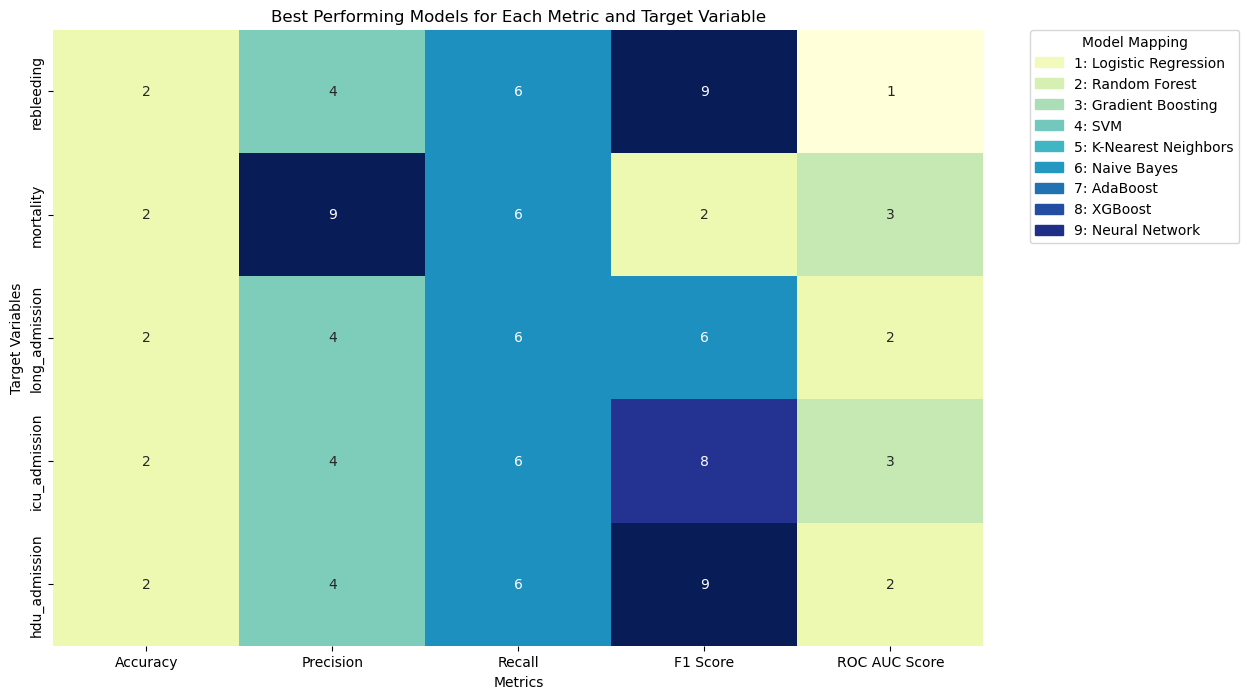

In [81]:
import seaborn as sns
import matplotlib.patches as mpatches
# Map model names to integers
model_mapping = {
    'Logistic Regression': 1,
    'Random Forest': 2,
    'Gradient Boosting': 3,
    'SVM': 4,
    'K-Nearest Neighbors': 5,
    'Naive Bayes': 6,
    'AdaBoost': 7,
    'XGBoost': 8,
    'Neural Network': 9
}

# Prepare the data for the heatmap
heatmap_data = pd.DataFrame.from_dict(best_models, orient='index').replace(model_mapping)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=False)
plt.title('Best Performing Models for Each Metric and Target Variable')
plt.xlabel('Metrics')
plt.ylabel('Target Variables')

# Create a custom legend
handles = [mpatches.Patch(color=sns.color_palette("YlGnBu", 9)[i], label=f'{i+1}: {model}') for i, model in enumerate(model_mapping)]
plt.legend(handles=handles, title='Model Mapping', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [82]:
#including GBS and Rockall
# GBS and Rockall performance metrics for each target variable
gbs_rockall_performance = {
    'rebleeding': {
        'GBS': {'Accuracy': 0.3530, 'Precision': 0.0941, 'Recall': 0.9310, 'F1 Score': 0.1710, 'ROC AUC Score': 0.6197},
        'Rockall': {'Accuracy': 0.2304, 'Precision': 0.0750, 'Recall': 0.8596, 'F1 Score': 0.1380, 'ROC AUC Score': 0.5208}
    },
    'mortality': {
        'GBS': {'Accuracy': 0.3598, 'Precision': 0.1139, 'Recall': 0.8691, 'F1 Score': 0.2014, 'ROC AUC Score': 0.5884},
        'Rockall': {'Accuracy': 0.2619, 'Precision': 0.1071, 'Recall': 0.9468, 'F1 Score': 0.1924, 'ROC AUC Score': 0.5693}
    },
    'long_admission': {
        'GBS': {'Accuracy': 0.3911, 'Precision': 0.1856, 'Recall': 0.8063, 'F1 Score': 0.3017, 'ROC AUC Score': 0.5582},
        'Rockall': {'Accuracy': 0.2979, 'Precision': 0.1718, 'Recall': 0.8649, 'F1 Score': 0.2867, 'ROC AUC Score': 0.5261}
    },
    'icu_admission': {
        'GBS': {'Accuracy': 0.3787, 'Precision': 0.1364, 'Recall': 0.9129, 'F1 Score': 0.2373, 'ROC AUC Score': 0.6142},
        'Rockall': {'Accuracy': 0.2646, 'Precision': 0.1167, 'Recall': 0.9050, 'F1 Score': 0.2067, 'ROC AUC Score': 0.5469}
    },
    'hdu_admission': {
        'GBS': {'Accuracy': 0.4127, 'Precision': 0.2128, 'Recall': 0.8371, 'F1 Score': 0.3393, 'ROC AUC Score': 0.5783},
        'Rockall': {'Accuracy': 0.3228, 'Precision': 0.1973, 'Recall': 0.8995, 'F1 Score': 0.3237, 'ROC AUC Score': 0.5478}
    }
}

# Adding GBS and Rockall performance metrics to results
for target in target_variables:
    results[target]['GBS'] = gbs_rockall_performance[target]['GBS']
    results[target]['Rockall'] = gbs_rockall_performance[target]['Rockall']

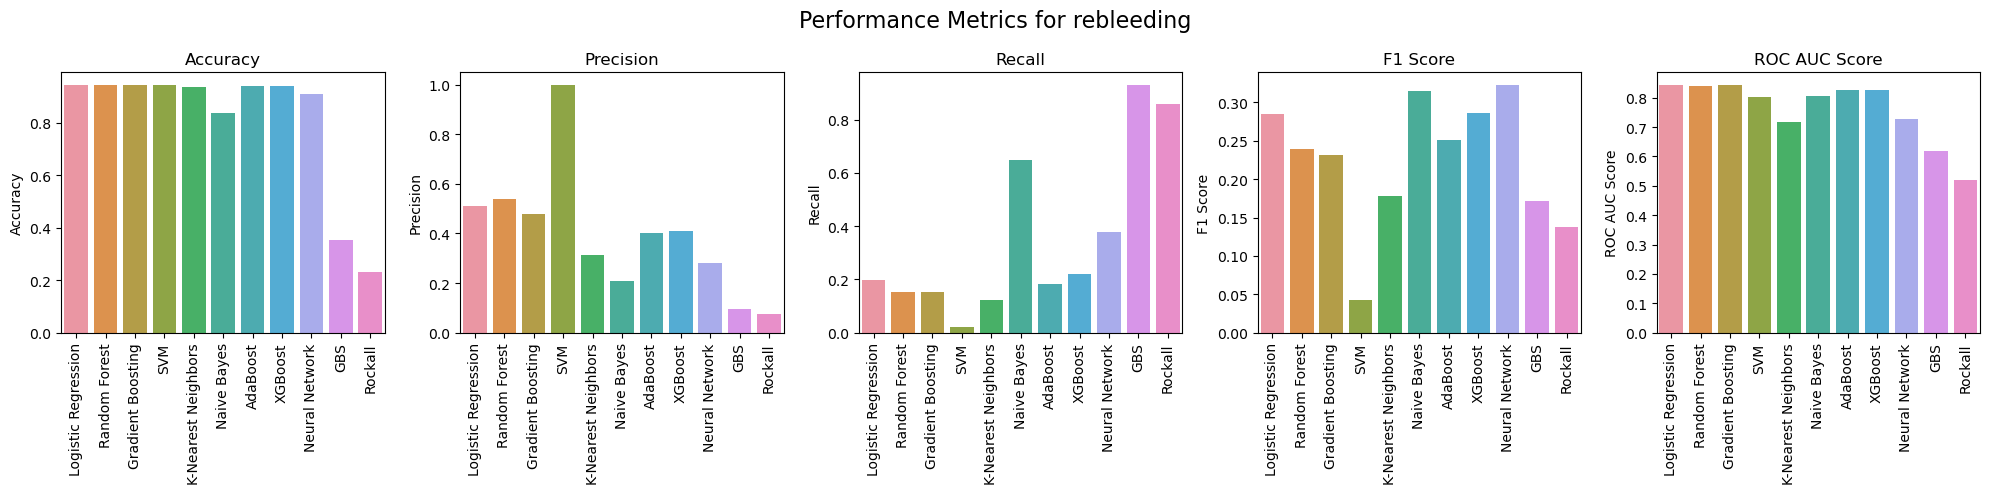

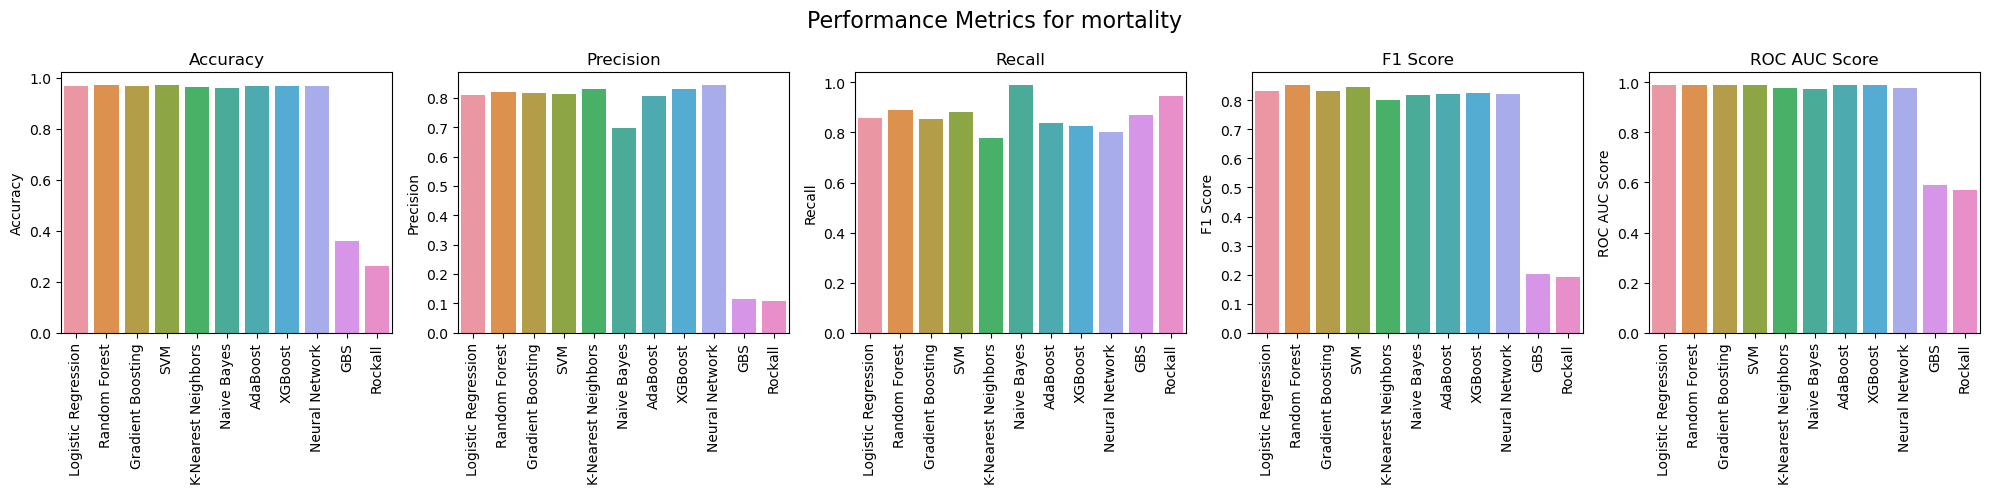

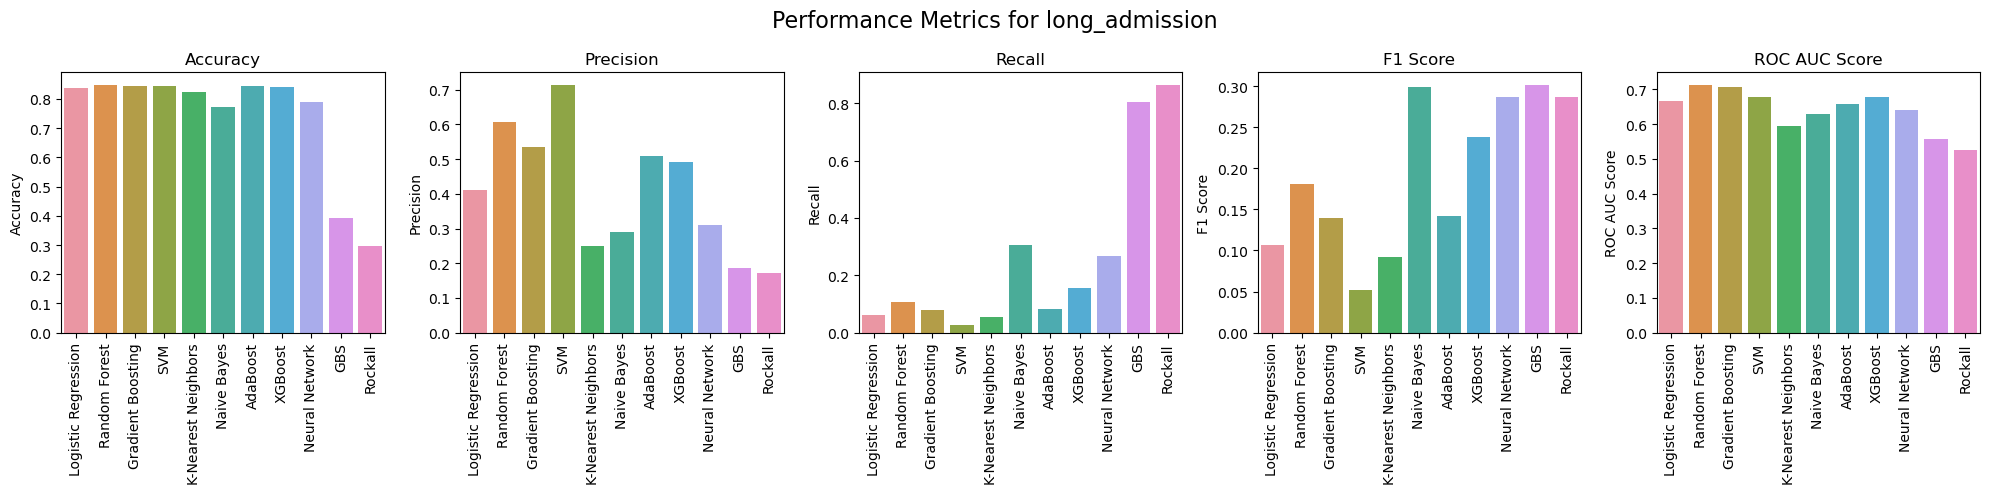

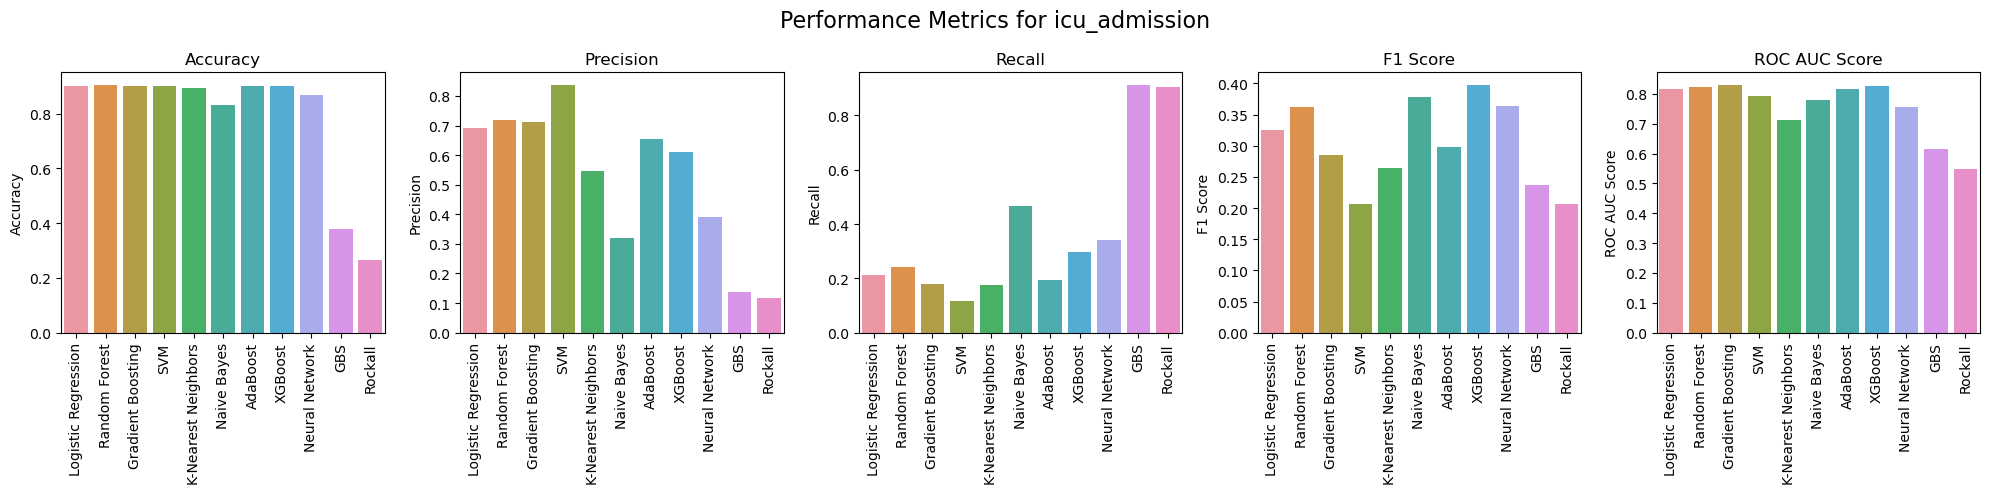

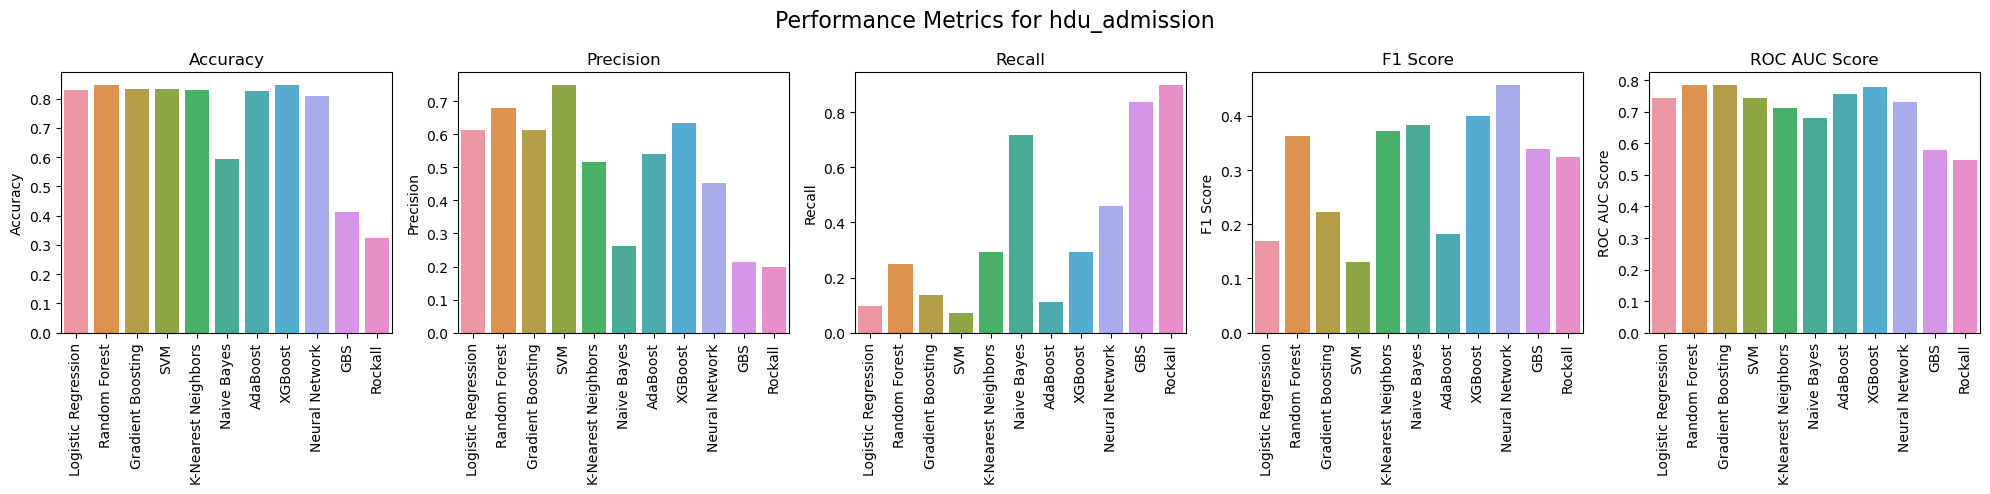

In [83]:
# Plot metrics for each target variable including GBS and Rockall scores
for target in target_variables:
    plot_metrics(results, target, metrics_to_plot)

In [78]:
import pandas as pd

# Function to create summary tables for performance metrics
def create_summary_table(results, target_variable, metrics):
    summary_data = {model: [results[target_variable][model][metric] for metric in metrics] 
                    for model in results[target_variable]}
    summary_df = pd.DataFrame(summary_data, index=metrics)
    return summary_df

# Create and display summary tables for each target variable
for target in target_variables:
    summary_table = create_summary_table(results, target, metrics_to_plot)
    print(f"Summary Table for {target}:")
    display(summary_table)
    print("\n")

Summary Table for rebleeding:


,Logistic Regression,Random Forest,Gradient Boosting,SVM,K-Nearest Neighbors,Naive Bayes,AdaBoost,XGBoost,Neural Network
Accuracy,0.943001,0.943839,0.941744,0.943839,0.934199,0.837385,0.937552,0.937133,0.908634
Precision,0.509434,0.538462,0.477273,1.000000,0.314815,0.207459,0.403226,0.410959,0.281081
Recall,0.197080,0.153285,0.153285,0.021898,0.124088,0.649635,0.182482,0.218978,0.379562
F1 Score,0.284211,0.238636,0.232044,0.042857,0.178010,0.314488,0.251256,0.285714,0.322981
ROC AUC Score,0.844314,0.840460,0.841842,0.801073,0.718142,0.806602,0.825832,0.826716,0.728012




Summary Table for mortality:


,Logistic Regression,Random Forest,Gradient Boosting,SVM,K-Nearest Neighbors,Naive Bayes,AdaBoost,XGBoost,Neural Network
Accuracy,0.968567,0.972339,0.968986,0.970662,0.965214,0.959765,0.966890,0.968567,0.968567
Precision,0.808696,0.821277,0.814978,0.812766,0.828431,0.695793,0.805310,0.828704,0.844660
Recall,0.857143,0.889401,0.852535,0.880184,0.778802,0.990783,0.838710,0.824885,0.801843
F1 Score,0.832215,0.853982,0.833333,0.845133,0.802850,0.817490,0.821670,0.826790,0.822695
ROC AUC Score,0.989485,0.990110,0.990387,0.988831,0.975667,0.975240,0.988058,0.988459,0.976606




Summary Table for long_admission:


,Logistic Regression,Random Forest,Gradient Boosting,SVM,K-Nearest Neighbors,Naive Bayes,AdaBoost,XGBoost,Neural Network
Accuracy,0.838642,0.848701,0.844510,0.845348,0.825231,0.773680,0.843252,0.841995,0.791282
Precision,0.410714,0.606061,0.535714,0.714286,0.250000,0.291139,0.508197,0.491667,0.309598
Recall,0.061333,0.106667,0.080000,0.026667,0.056000,0.306667,0.082667,0.157333,0.266667
F1 Score,0.106729,0.181406,0.139211,0.051414,0.091503,0.298701,0.142202,0.238384,0.286533
ROC AUC Score,0.665651,0.713719,0.707356,0.678275,0.596052,0.630689,0.658529,0.678919,0.640021




Summary Table for icu_admission:


,Logistic Regression,Random Forest,Gradient Boosting,SVM,K-Nearest Neighbors,Naive Bayes,AdaBoost,XGBoost,Neural Network
Accuracy,0.902347,0.905700,0.901090,0.899832,0.892707,0.830679,0.899413,0.901090,0.867980
Precision,0.691358,0.719101,0.712121,0.837838,0.547619,0.318653,0.653846,0.609375,0.389610
Recall,0.212121,0.242424,0.178030,0.117424,0.174242,0.465909,0.193182,0.295455,0.340909
F1 Score,0.324638,0.362606,0.284848,0.205980,0.264368,0.378462,0.298246,0.397959,0.363636
ROC AUC Score,0.815917,0.821127,0.830351,0.791628,0.711263,0.780019,0.816453,0.826536,0.756473




Summary Table for hdu_admission:


,Logistic Regression,Random Forest,Gradient Boosting,SVM,K-Nearest Neighbors,Naive Bayes,AdaBoost,XGBoost,Neural Network
Accuracy,0.830679,0.847443,0.833194,0.832775,0.827745,0.594300,0.827326,0.846186,0.808047
Precision,0.611940,0.679739,0.612903,0.750000,0.516949,0.261512,0.541176,0.635417,0.454118
Recall,0.097852,0.248210,0.136038,0.071599,0.291169,0.718377,0.109785,0.291169,0.460621
F1 Score,0.168724,0.363636,0.222656,0.130719,0.372519,0.383439,0.182540,0.399345,0.457346
ROC AUC Score,0.742277,0.785803,0.785226,0.743656,0.712097,0.681404,0.756143,0.777080,0.732568


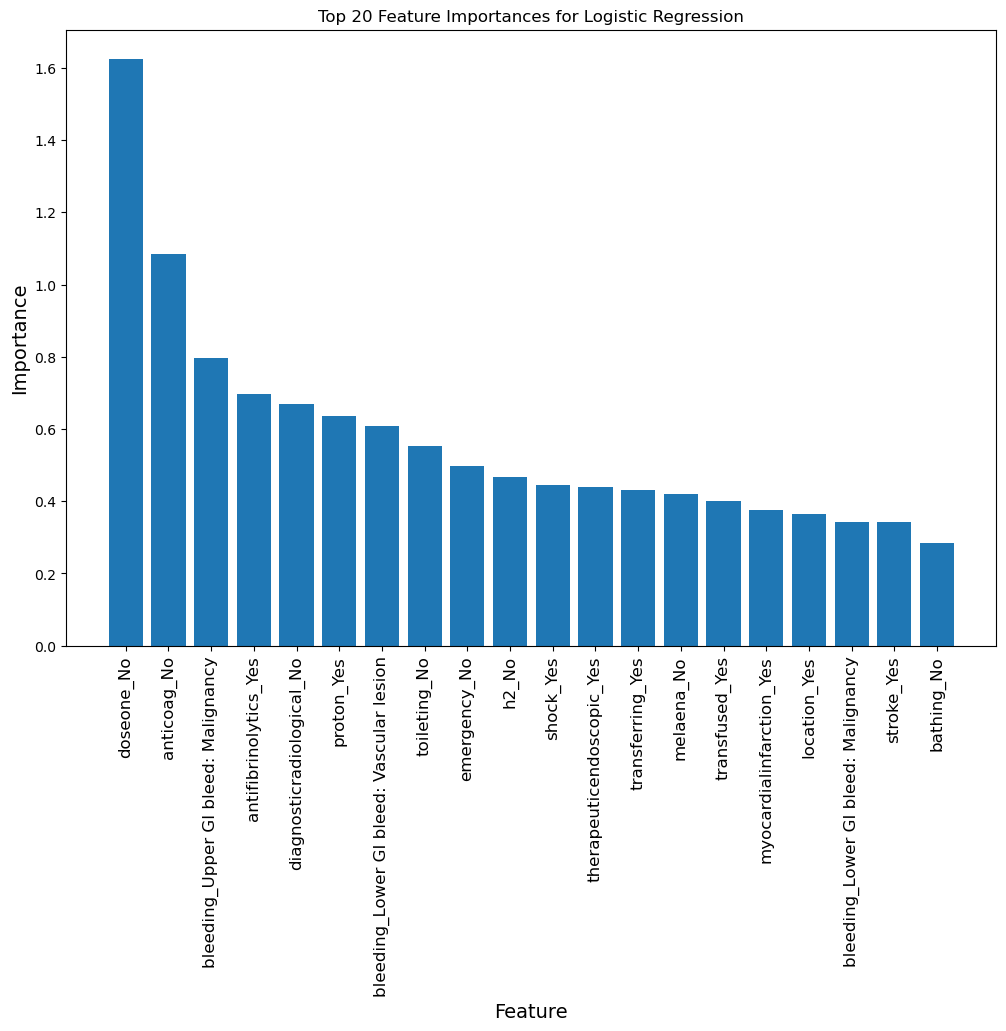

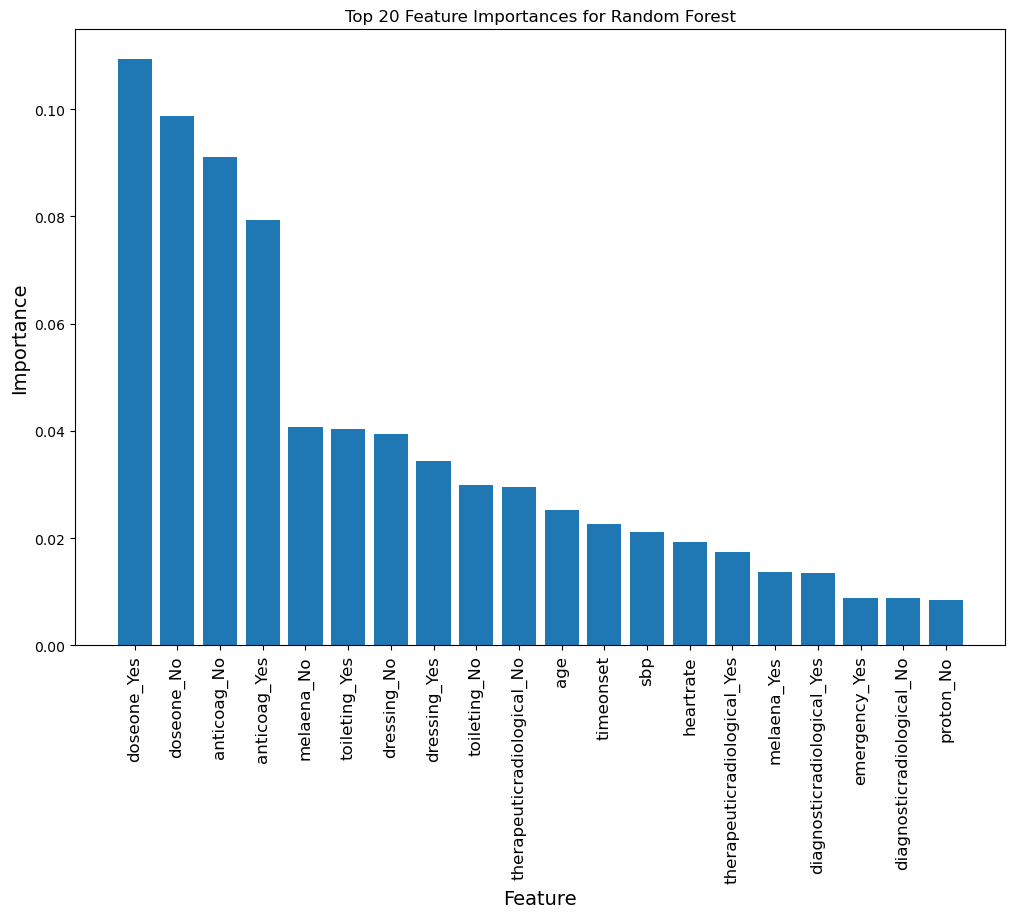

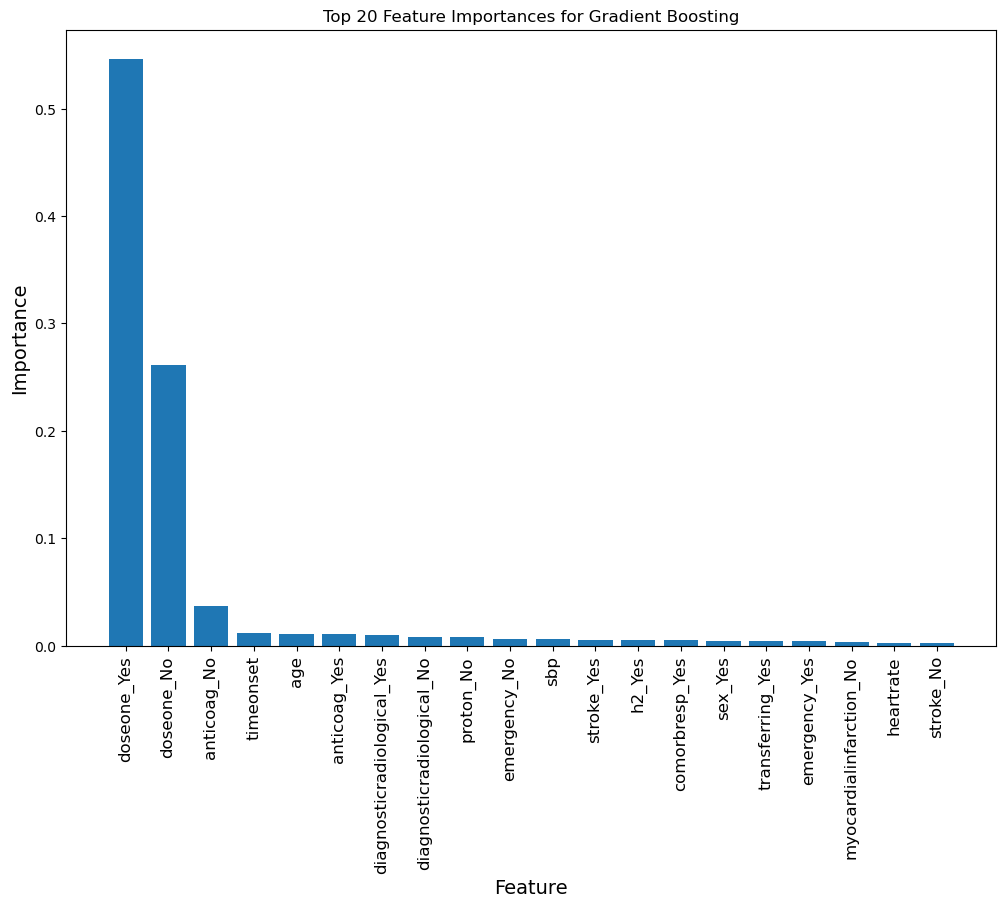

Model SVM does not support feature importances.
Model K-Nearest Neighbors does not support feature importances.
Model Naive Bayes does not support feature importances.


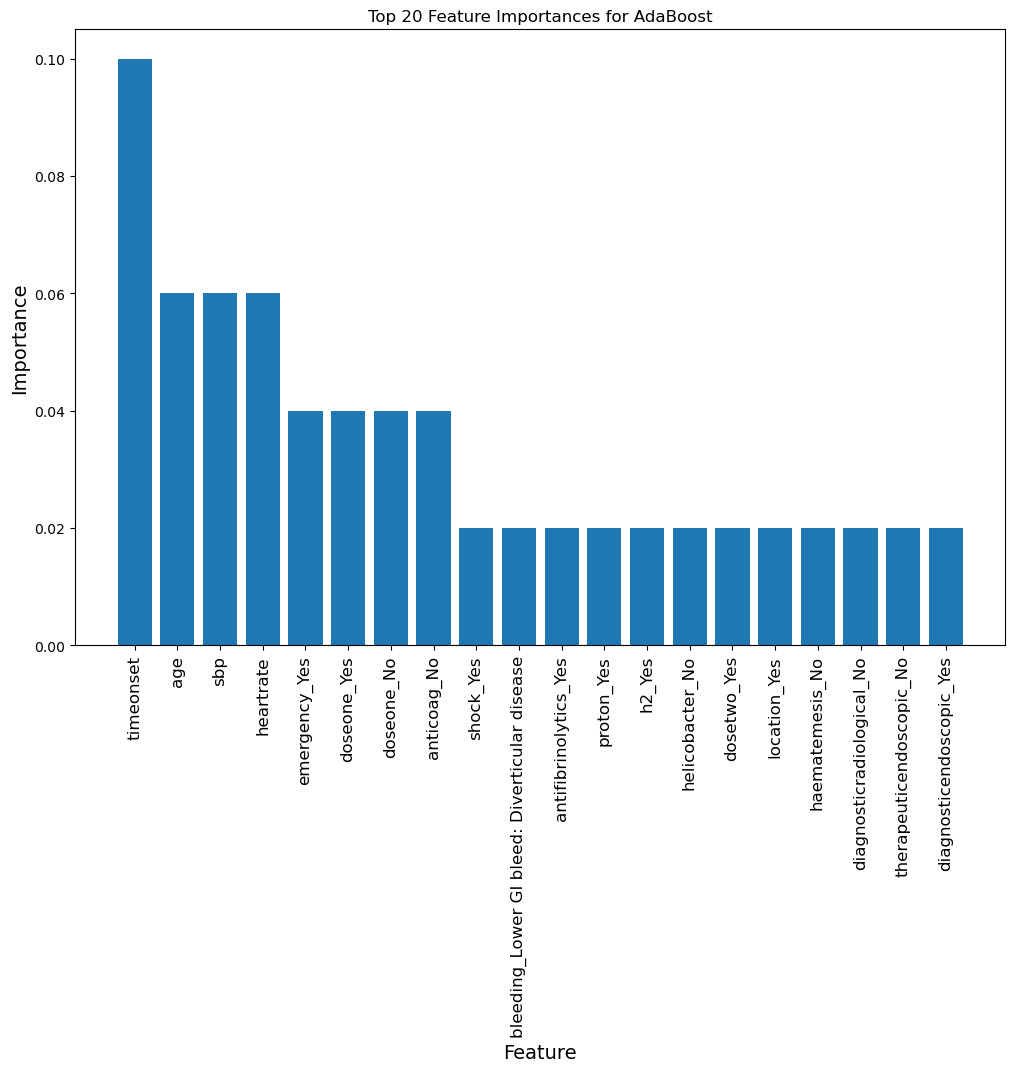

/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:36:28] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


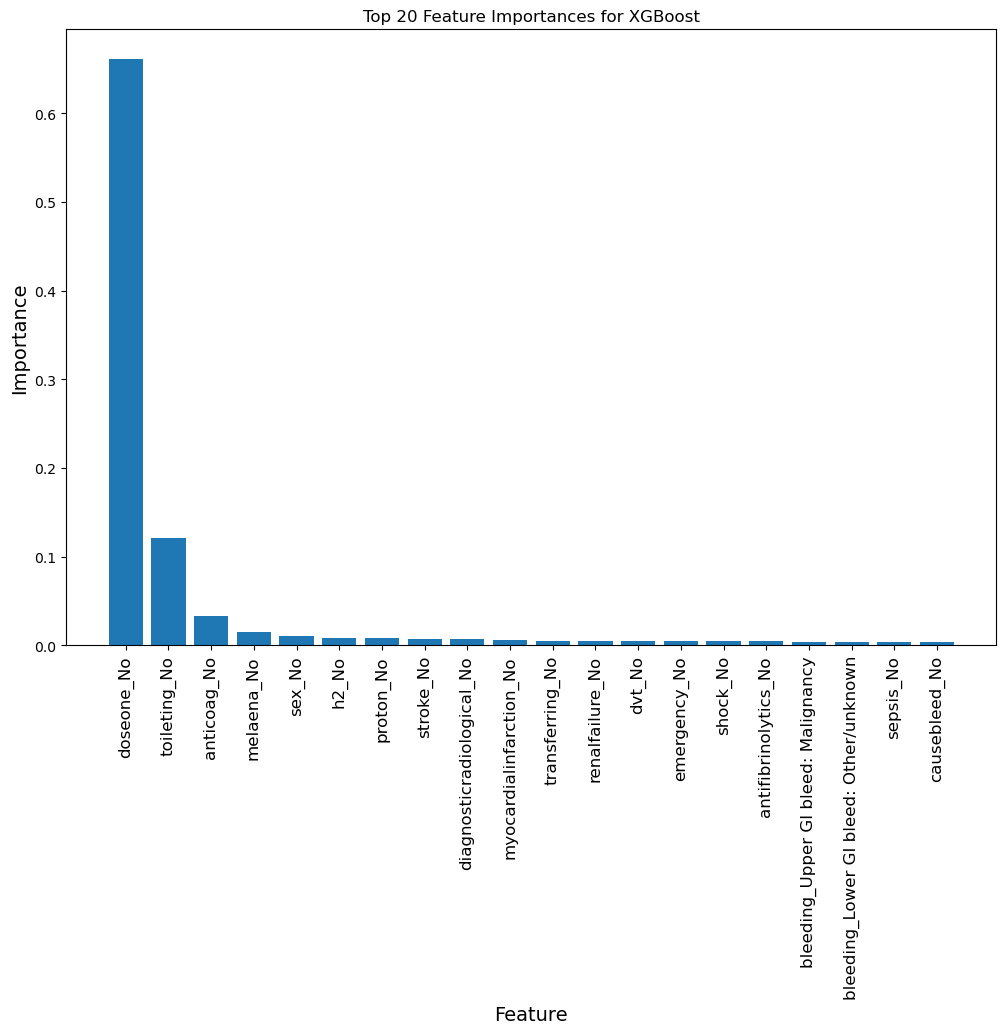

Model Neural Network does not support feature importances.


In [3]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'Neural Network': MLPClassifier(max_iter=10000)
}

# Load preprocessor to get feature names
preprocessor = joblib.load('preprocessor.joblib')

# Ensure numerical_features and categorical_features are defined
numerical_features = ['age', 'timeonset', 'sbp', 'heartrate']  # example numerical features
categorical_features = ['sex', 'location', 'haematemesis', 'melaena', 'variceal', 'shock', 'bleeding', 
                        'comorbcv', 'comorbresp', 'comorbliver', 'comorbrenal', 'comorbmalig', 
                        'comorbother', 'anticoag', 'emergency', 'diagnosticendoscopic', 
                        'therapeuticendoscopic', 'diagnosticradiological', 'therapeuticradiological', 
                        'surgicalintervention', 'causebleed', 'doseone', 'dosetwo', 'helicobacter', 
                        'h2', 'proton', 'vasopressin', 'antibiotics', 'antifibrinolytics', 
                        'transfused', 'dvt', 'pe', 'stroke', 'myocardialinfarction', 
                        'cardiacevent', 'sepsis', 'pneumonia', 'respiratoryfailure', 
                        'liverfailure', 'renalfailure', 'seizure', 'bathing', 'dressing', 
                        'toileting', 'transferring', 'continence', 'feeding']  # example categorical features

# Function to get feature names after one-hot encoding
def get_feature_names(preprocessor, numerical_features, categorical_features):
    num_features = numerical_features
    cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
    return np.concatenate([num_features, cat_features])

feature_names = get_feature_names(preprocessor, numerical_features, categorical_features)

# Function to plot feature importances
def plot_feature_importances(model, model_name, feature_names, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
    else:
        print(f"Model {model_name} does not support feature importances.")
        return
    
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances for {model_name}")
    plt.bar(range(top_n), importances[top_indices], align="center")
    plt.xticks(range(top_n), feature_names[top_indices], rotation=90, fontsize=12)
    plt.xlabel("Feature", fontsize=14)
    plt.ylabel("Importance", fontsize=14)
    plt.show()

# Load models and plot feature importances for mortality prediction as an example
for model_name in models.keys():
    model = joblib.load(f"{model_name}_mortality.joblib")
    plot_feature_importances(model, model_name, feature_names)

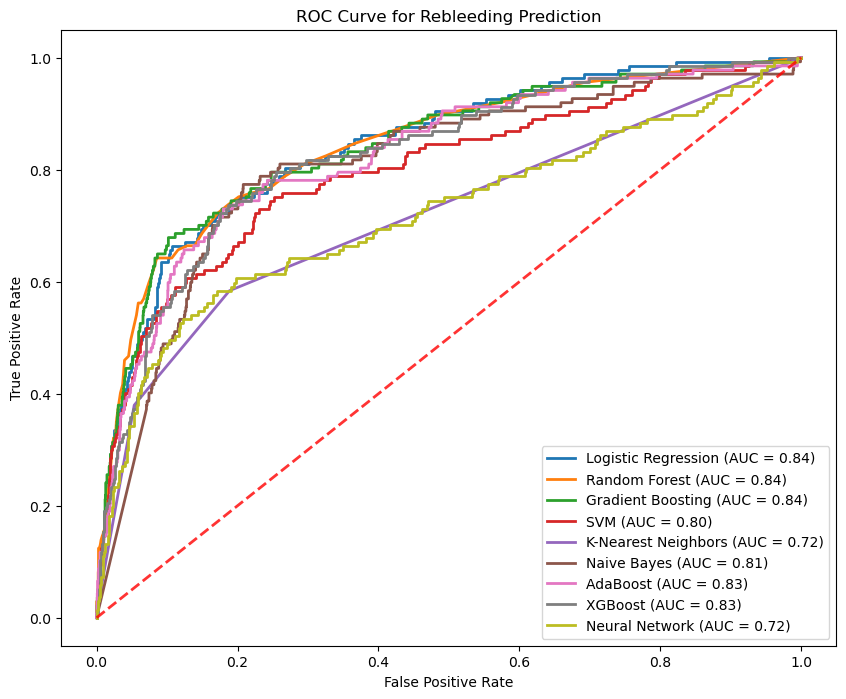

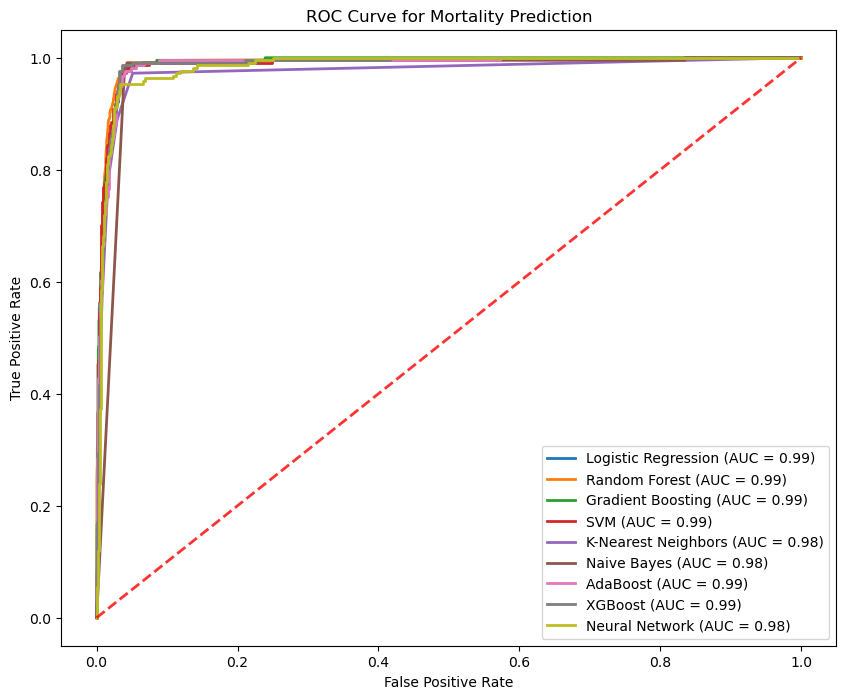

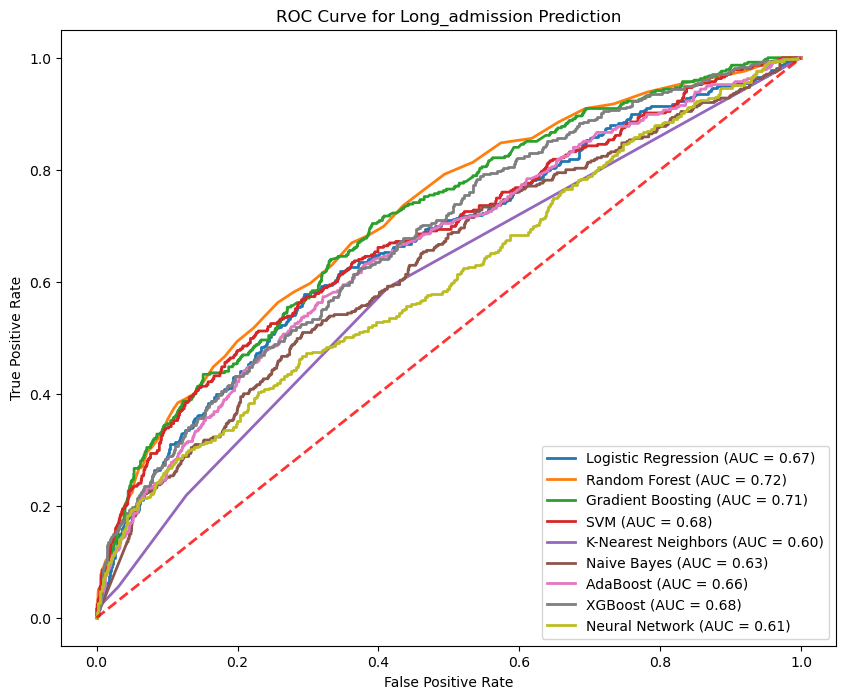

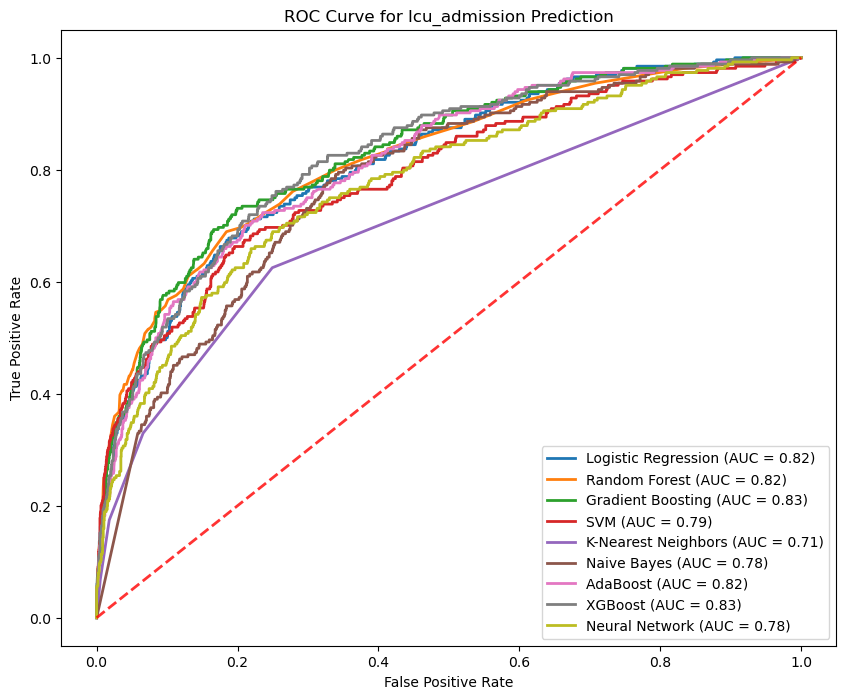

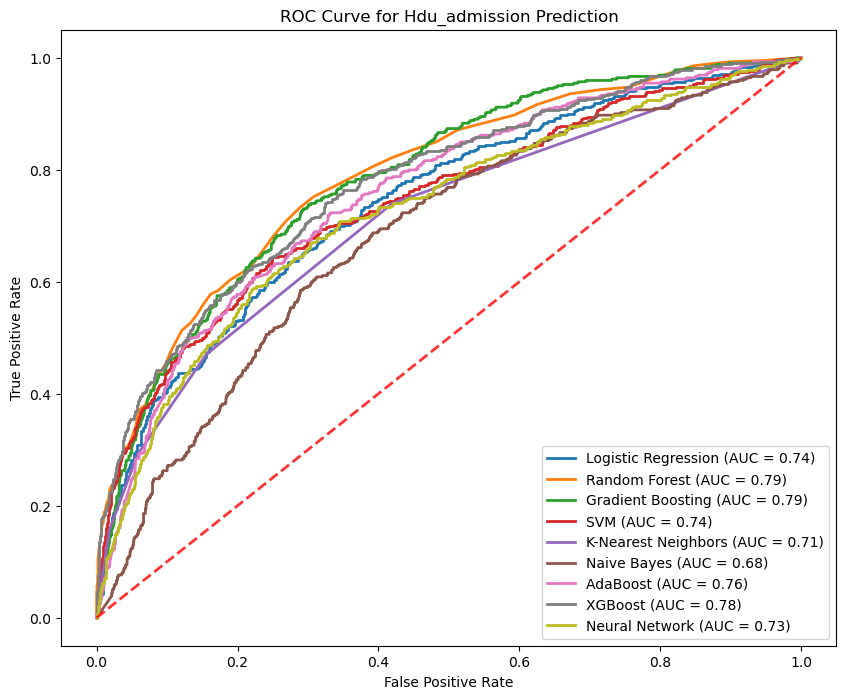

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curves
def plot_roc_curve(models, X_test, y_test, title):
    plt.figure(figsize=(10, 8))
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(X_test)
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plotting ROC curves for each target variable
for target in ['rebleeding', 'mortality', 'long_admission', 'icu_admission', 'hdu_admission']:
    X_train = globals()[f'X_train']
    X_test = globals()[f'X_test']
    y_train = globals()[f'y_train_{target}']
    y_test = globals()[f'y_test_{target}']

    for model_name, model in models.items():
        model.fit(X_train, y_train)

    plot_roc_curve(models, X_test, y_test, f'ROC Curve for {target.capitalize()} Prediction')

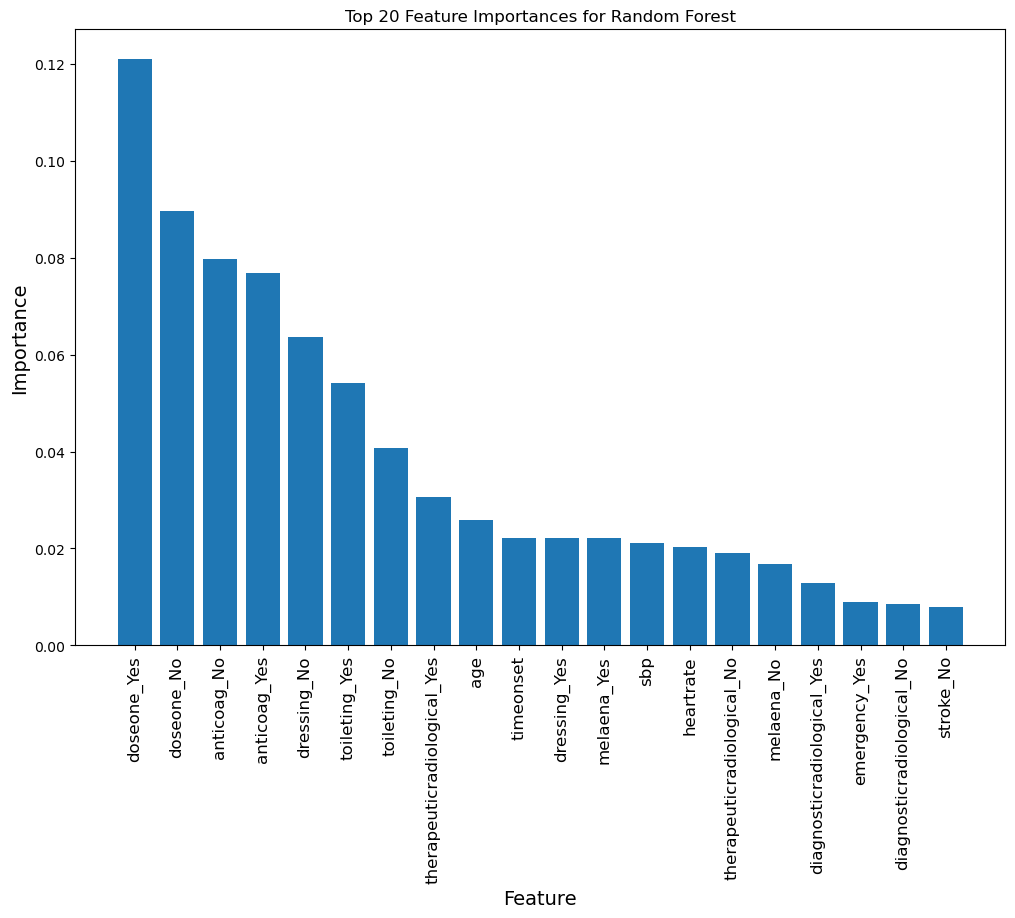

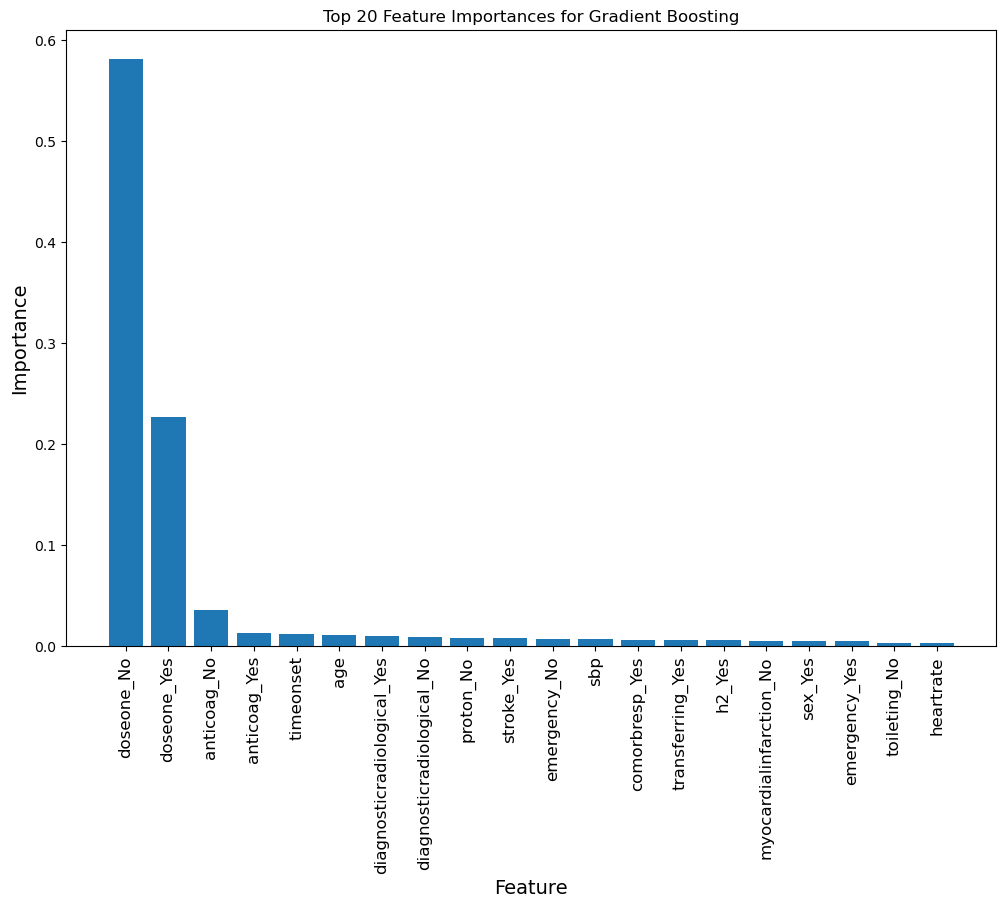

Model Neural Network does not support feature importances.


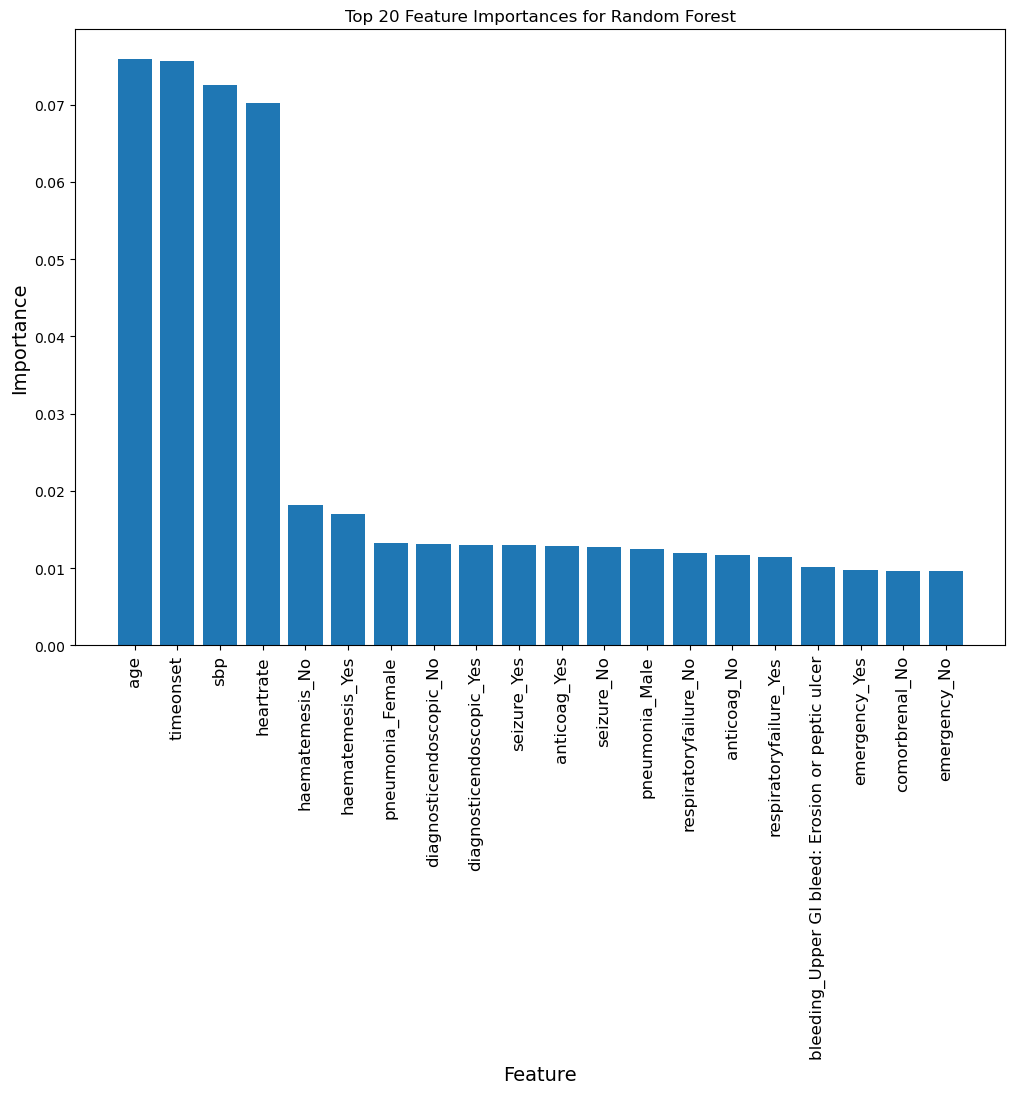

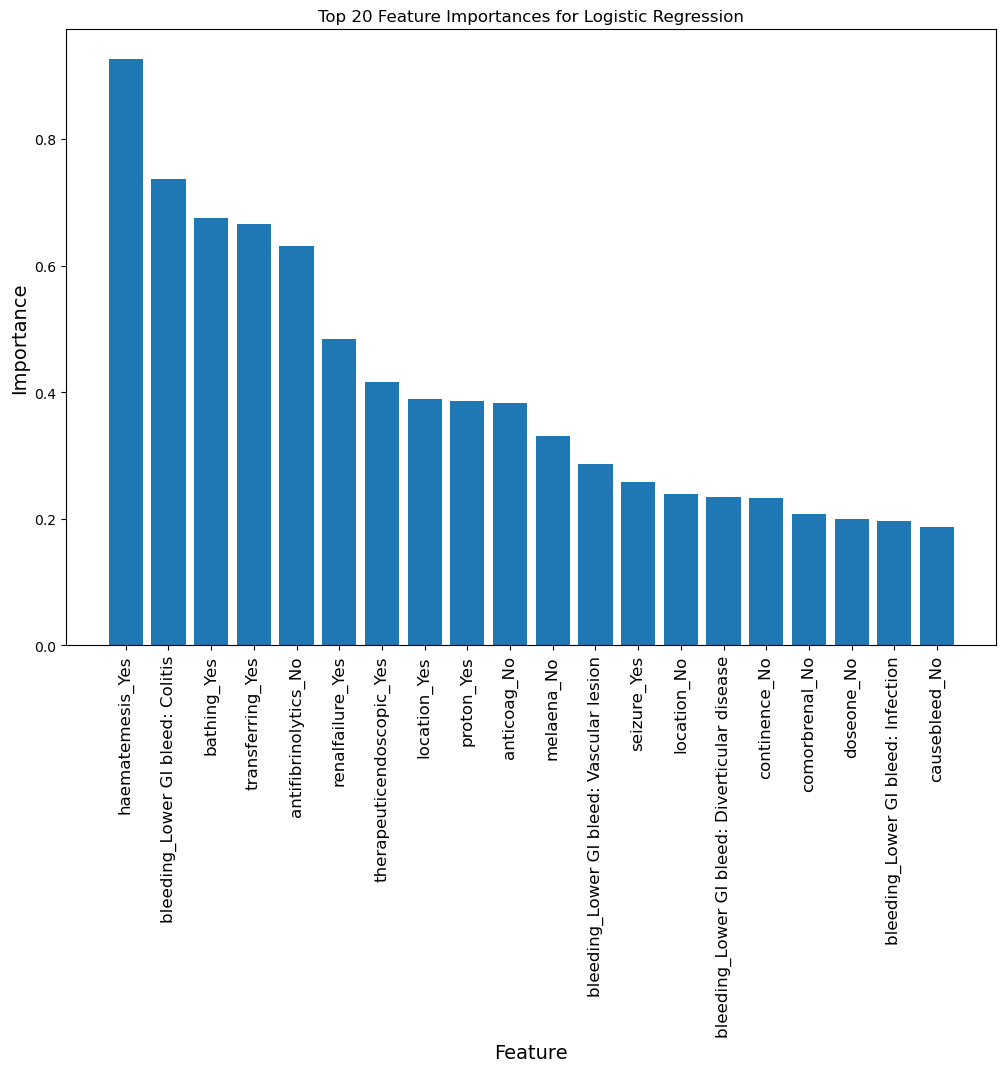

Model K-Nearest Neighbors does not support feature importances.


In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot feature importances
def plot_feature_importances(model, model_name, feature_names, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
    else:
        print(f"Model {model_name} does not support feature importances.")
        return
    
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    
    plt.figure(figsize=(12, 8))
    plt.title(f"Top {top_n} Feature Importances for {model_name}")
    plt.bar(range(top_n), importances[top_indices], align="center")
    plt.xticks(range(top_n), [feature_names[i] for i in top_indices], rotation=90, fontsize=12)
    plt.xlabel("Feature", fontsize=14)
    plt.ylabel("Importance", fontsize=14)
    plt.show()

# Manually specify the best model names based on your results
best_model_names = {
    'mortality': ['Random Forest','Gradient Boosting','Neural Network'] ,
    'rebleeding': ['Random Forest','Logistic Regression','K-Nearest Neighbors']    
    # Add more if needed for other tasks
}

# Plot feature importances for each task
for target, model_names in best_model_names.items():
    for model_name in model_names:
        model = best_models[target][model_name]
        plot_feature_importances(model, model_name, feature_names)